# Austin Animal Shelter: What puts an animal at risk of having a longer adoption time?
This analysis is based on [Austin Animal Shelter](http://www.austintexas.gov/department/aac) data from 2014 to 2018. Data are available through [Kaggle](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes#aac_intakes_outcomes.csv).

<img src="http://www.austintexas.gov/sites/default/files/aac_logo.jpg" width=400px align="center"><br>
[Image Credit](http://www.austintexas.gov/department/aac)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('aac_intakes_outcomes.csv', parse_dates=True)

In [3]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

np.random.seed(47)
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

# Dataset Overview

In [4]:
df.shape

(79672, 41)

In [5]:
df.head()

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889
3,10 years,A047759,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,...,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139
4,16 years,A134067,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,...,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79672 entries, 0 to 79671
Data columns (total 41 columns):
age_upon_outcome              79672 non-null object
animal_id_outcome             79672 non-null object
date_of_birth                 79672 non-null object
outcome_subtype               36348 non-null object
outcome_type                  79662 non-null object
sex_upon_outcome              79671 non-null object
age_upon_outcome_(days)       79672 non-null int64
age_upon_outcome_(years)      79672 non-null float64
age_upon_outcome_age_group    79672 non-null object
outcome_datetime              79672 non-null object
outcome_month                 79672 non-null int64
outcome_year                  79672 non-null int64
outcome_monthyear             79672 non-null object
outcome_weekday               79672 non-null object
outcome_hour                  79672 non-null int64
outcome_number                79672 non-null float64
dob_year                      79672 non-null int64
dob_month 

In [7]:
df.outcome_datetime = pd.to_datetime(df.outcome_datetime)

# Cats have longer adoption times than other animals.
- This dataset includes data for dogs, cats, birds, and "other", which include animals such as rabbits. 
- Dogs were the most common animal type.

<img src="https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png" width=400px align="center"><br>
[Image Credit](https://icatcare.org/advice/thinking-of-getting-a-cat/)

In [8]:
df['animal_type'].unique()

array(['Dog', 'Cat', 'Other', 'Bird'], dtype=object)

In [9]:
df['animal_type'].describe()

count     79672
unique        4
top         Dog
freq      45366
Name: animal_type, dtype: object

Although dogs are more common in this dataset, they take less time on average to adoption than cats.

Text(0, 0.5, 'Time in Shelter (Days)')

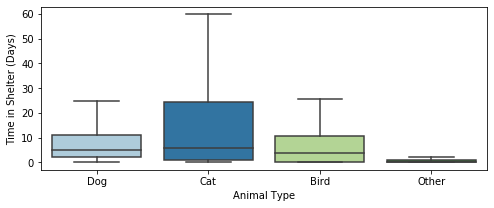

In [10]:
plt.figure(figsize=(8,3))
ax = sns.boxplot(x='animal_type', y='time_in_shelter_days', 
                 palette='Paired', data=df, showfliers=False, order=['Dog', 'Cat', 'Bird', 'Other'])
ax.set_xlabel('Animal Type')
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Number of Animals')

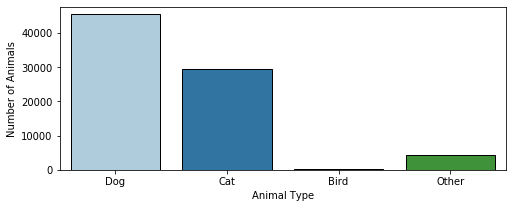

In [11]:
plt.figure(figsize=(8,3))
sns.barplot(x=df.groupby('animal_type').count().index, 
            y=df.groupby('animal_type').count()['age_upon_outcome'], 
            data=df.groupby('animal_type').count(), palette='Paired', 
            ec='black', order=['Dog', 'Cat', 'Bird', 'Other'])
plt.xlabel('Animal Type')
plt.ylabel('Number of Animals')

In [12]:
stats.f_oneway(df.loc[df['animal_type']=='Dog', 'time_in_shelter_days'], 
               df.loc[df['animal_type']=='Cat', 'time_in_shelter_days'],
               df.loc[df['animal_type']=='Other', 'time_in_shelter_days'],
               df.loc[df['animal_type']=='Bird', 'time_in_shelter_days'])

F_onewayResult(statistic=213.86650584590905, pvalue=3.475025206157899e-138)

In [13]:
animals = df['animal_type'].unique()
def ttest_all(categorical_list, df_name, categorical_variable, test_variable):
    
    df_list = []
    for i in categorical_list:
        others = df_name[df_name[categorical_variable]!=i]
        i_var = df_name[df_name[categorical_variable]==i]
        i_mean = np.mean(i_var[test_variable])
        o_mean = np.mean(others[test_variable])
        ttest, pvalue = stats.ttest_ind(i_var[test_variable], others[test_variable], equal_var=False)
        df_list.append([i, i_mean, o_mean, ttest, pvalue])

    pval = pd.DataFrame(df_list)
    pval.columns = ['Variable', 'Mean', 'Mean of Others', 'Test Statistic', 'p-value']
    return pval

ttest_all(animals, df, 'animal_type', 'time_in_shelter_days')

,Variable,Mean,Mean of Others,Test Statistic,p-value
0,Dog,15.897242,17.894206,-6.851339,7.369769e-12
1,Cat,20.087695,14.794696,17.707777,5.308506e-70
2,Other,4.018686,17.506754,-41.461970,0.000000e+00
3,Bird,8.004333,16.794517,-13.029323,3.035600e-32


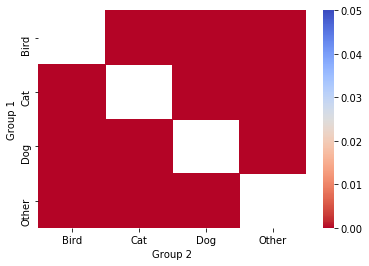

In [14]:
animals = df['animal_type'].unique()
def pairwise_ttest(categorical_list, df_name, category_variable, test_variable, graph=False):
    test_list = []
    for i in range(len(categorical_list)):
        c = categorical_list[i]
        df_c = df_name.loc[df_name[category_variable]==c, test_variable]
        test_list.append(df_c)
    
    df_list = []
    for i, x in enumerate(test_list):
         for j,y in enumerate(test_list):
                if i!=j:
                    name_1 = categorical_list[i]
                    name_2 = categorical_list[j]
                    ttest, pvalue = stats.ttest_ind(x, y, equal_var=False)
                    df_list.append([name_1, name_2, ttest, pvalue])

    pval = pd.DataFrame(df_list)
    pval.columns = ['Group 1', 'Group 2', 'Test Statistic', 'p-value']
    pval = pval.pivot('Group 1', 'Group 2', 'p-value')
    
    if graph==False:
        return pval
    else:
        ax = sns.heatmap(pval, cmap='coolwarm_r', vmin=0, vmax=.05)
            
pairwise_ttest(animals, df, 'animal_type', 'time_in_shelter_days',  graph=True)

## There are a lot of outliers in this data.
Note that the boxplots in this seciton have fliers hidden. If fliers are shown, the graphs are impossible to interpret - we'll look at that later. Here is an example of the above graph with fliers shown:

Text(0, 0.5, 'Time in Shelter (Days)')

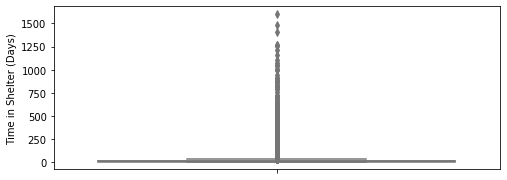

In [205]:
plt.figure(figsize=(8, 3))
ax = sns.boxplot(y='time_in_shelter_days', palette='Paired', data=df)
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Time in Shelter (Days)')

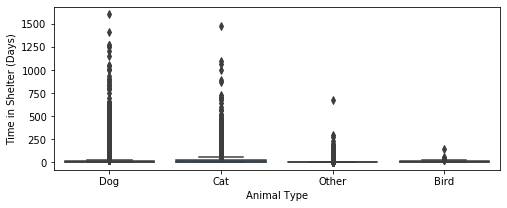

In [15]:
plt.figure(figsize=(8, 3))
ax = sns.boxplot(x='animal_type', y='time_in_shelter_days', palette='Paired', data=df)
ax.set_xlabel('Animal Type')
plt.ylabel('Time in Shelter (Days)')

# Extreme outliers in this dataset make it difficult to draw meaningful predictions

Here, we see that most of the adoption time data fall to the extreme left end of the axis, with the mean shown in purple. Looking at the mean and median for shelter times supports this: while the median is almost 17 days, the mean is only ~5 days. Additionally, 95% of the animals are adopted in less than ~71 days.

Text(0.5, 0, 'Time in Shelter (Days)')

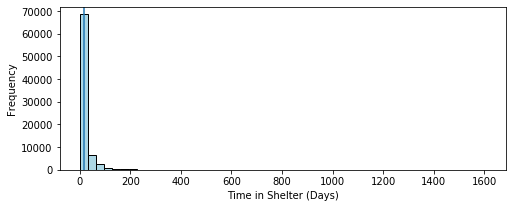

In [16]:
plt.figure(figsize=(8,3))
ax = df.time_in_shelter_days.plot(kind='hist', bins=50, color='LightBlue', ec='black')
ax.axvline(df.time_in_shelter_days.mean())
ax.set_xlabel('Time in Shelter (Days)')

In [174]:
mean = np.mean(df.time_in_shelter_days)
median = np.median(df.time_in_shelter_days)
mean, median

(16.75711554526339, 4.987152777777778)

In [207]:
std = np.std(df.time_in_shelter_days)
mean + 3*std

141.79440897951

In [18]:
# We'll use this cutoff to exclude outliers
outliers = df.time_in_shelter_days.quantile(0.95)
outliers

71.10881944444444

This distribution makes it easier to see an exponential trend in adoption times.

Text(0.5, 0, 'Time in Shelter (Days)')

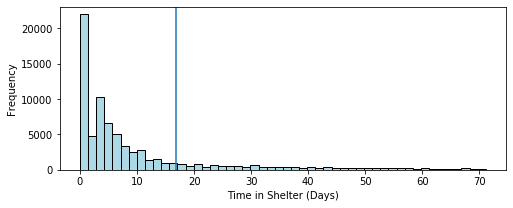

In [19]:
plt.figure(figsize=(8,3))
ax = df[df.time_in_shelter_days<outliers].time_in_shelter_days.plot(kind='hist', bins=50, color='LightBlue', ec='black')
ax.axvline(df.time_in_shelter_days.mean())
ax.set_xlabel('Time in Shelter (Days)')

# For <71 time in shelter days

***
# A closer look at man's best friend
What puts a dog at a higher risk of having a long adoption time?

<img src="http://wholesolutionsgroup.com/wp-content/uploads/2016/08/Man-and-Dog--1080x675.jpg" width=400px align=center><br>
[Image Credit](http://wholesolutionsgroup.com/why-dogs-are-mans-best-friend/)

## Does dog breed affect adoption time?
In this section, I hypothesized that stereotypically common shelter breeds, such as ***Pit Bulls and Chihuahuas***,  have longer adoption times than other breeds. 

<img src="https://assets3.thrillist.com/v1/image/2775369/size/tmg-article_tall.jpg" width=400px align="center"><br>
[Image Credit](https://www.thedodo.com/close-to-home/pit-bull-dog-carries-chihuahua-friend)

In [20]:
df_clean = df[df['time_in_shelter_days']<outliers]

In [21]:
dogs = df_clean[df_clean['animal_type'] == 'Dog']
cats = df_clean[df_clean['animal_type'] == 'Cat']
birds = df_clean[df_clean['animal_type'] == 'Bird']
other = df_clean[df_clean['animal_type'] == 'Other']

### Pit bulls and chihuahuas do represent the most common breeds at this shelter.

In [22]:
dogs['breed'].value_counts().head()

Pit Bull Mix                 5610
Chihuahua Shorthair Mix      4722
Labrador Retriever Mix       4591
German Shepherd Mix          1902
Australian Cattle Dog Mix    1033
Name: breed, dtype: int64

Because many of the animals at this shelter were categorized as mixed breeds, it became impossible to see patterns by breed - there were 1919 unique breed categorizations. To simplify this analysis, I sorted the data such that each breed is a unique column, and each animal has a 1 or 0 based on whether it is in part or full that breed. I further created a mixed breed/purebred column to later analyze whether purebreds are adopted more quickly than mixed breeds.

In [23]:
dogs['breed'].nunique()

1883

In [24]:
dogs['breed'] = dogs['breed'].str.replace('Black/Tan Hound', 'Black-Tan Hound')
dogs['breed'] = dogs['breed'].str.replace(' Shorthair', '')
dogs['breed'] = dogs['breed'].str.replace(' Longhair', '')
dogs['breed_nomix'] = dogs['breed'].str.replace(' Mix', '')
dogs['breed_list'] = dogs['breed_nomix'].str.split('/')
dogs.loc[dogs.breed_list.str.len()>1, 'mixed_breed'] = 'Mixed Breed'
dogs.loc[dogs['breed'].str.contains('Mix'), 'mixed_breed'] = 'Mixed Breed'
dogs['mixed_breed'] = dogs['mixed_breed'].fillna('Purebred')
#dogs.sort_index(axis=0)

In [25]:
has_breeds = pd.get_dummies(dogs['breed_list'].apply(pd.Series).stack()).sum(level=0)

In [26]:
dog_breeds_combined = pd.concat([dogs, has_breeds], axis=1)

In [212]:
breed_melt1 = dog_breeds_combined[['breed','breed_list', 'mixed_breed', 'time_in_shelter_days']]
breed_melt2 = dog_breeds_combined.loc[:, 'Affenpinscher':]
breed_melt = pd.concat([breed_melt1, breed_melt2], axis=1)
dog_breeds = pd.melt(breed_melt, id_vars=['breed_list','mixed_breed','time_in_shelter_days'], 
                       var_name='breed_name', value_name='has_breed')
dog_breeds.loc[dog_breeds['has_breed']==1, 'breed'] = dog_breeds['breed_name']

In [213]:
dog_breeds

,breed_list,mixed_breed,time_in_shelter_days,breed_name,has_breed,breed
0,[Spinone Italiano],Mixed Breed,0.588194,breed,Spinone Italiano Mix,NaN
1,[Spinone Italiano],Mixed Breed,1.259722,breed,Spinone Italiano Mix,NaN
2,[Spinone Italiano],Mixed Breed,1.113889,breed,Spinone Italiano Mix,NaN
3,[Dachshund],Purebred,4.970139,breed,Dachshund,NaN
4,[Shetland Sheepdog],Purebred,0.119444,breed,Shetland Sheepdog,NaN
5,"[Labrador Retriever, Pit Bull]",Mixed Breed,0.870833,breed,Labrador Retriever/Pit Bull,NaN
6,[Miniature Schnauzer],Mixed Breed,0.178472,breed,Miniature Schnauzer Mix,NaN
7,[Lhasa Apso],Mixed Breed,0.213194,breed,Lhasa Apso Mix,NaN
8,[Shetland Sheepdog],Mixed Breed,6.258333,breed,Shetland Sheepdog Mix,NaN
9,[Shetland Sheepdog],Mixed Breed,0.054167,breed,Shetland Sheepdog Mix,NaN


#### I grouped dog breeds that occur <400 times into a group called "other" to see only the most common breeds.

In [28]:
common_breeds = dog_breeds.groupby('breed').sum()
common_breeds = common_breeds.sort_values('has_breed', ascending=False)
other_breeds = common_breeds.loc[common_breeds['has_breed']<400,:]
other_breeds_list = other_breeds.index.tolist()

In [29]:
dog_breeds.loc[dog_breeds['breed'].isin(other_breeds_list), 'breed_category'] = 'Other'
dog_breeds.loc[~dog_breeds['breed'].isin(other_breeds_list), 'breed_category'] = dog_breeds['breed']

In [30]:
sortgroup = dog_breeds.groupby('breed_category').mean().sort_values('time_in_shelter_days', ascending=False)
sortgroup = sortgroup['time_in_shelter_days'].to_dict()

## American Bull Dogs and Staffordshires beat out Pit Bulls with the longest adoption times.
### Additionally, Chihuahuas are fairly far down the list.

Interestingly, purebred Pit Bulls had ***longer*** adoption times than mixed breed Pit Bulls, perhaps due to prevalent stereotypes about this breed. The same applied to Staffordshires; however, most other breeds had faster adoption times in purebreds.
The graph below is sorted L-R by mean adoption times.

<img src="https://i0.wp.com/puppytoob.com/wp-content/uploads/2017/04/American-bulldog-640x427.jpg?resize=640%2C427&ssl=1" width=400px align="center"><br>
[Image Credit](https://puppytoob.com/7-important-tips-taking-care-american-bulldog/)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

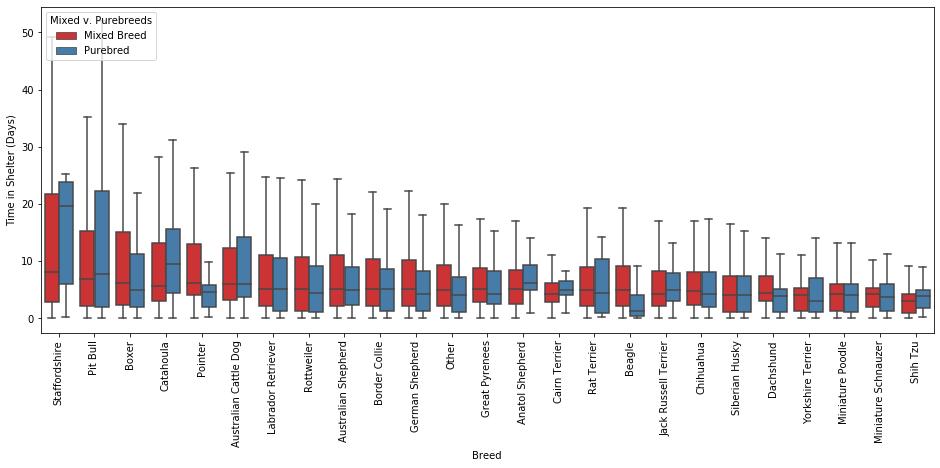

In [31]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='breed_category', y='time_in_shelter_days', hue='mixed_breed', 
                    data=dog_breeds, palette='Set1', showfliers=False, order=sortgroup)
plt.xlabel('Breed')
plt.ylabel('Time in Shelter (Days)')
plt.legend(title='Mixed v. Purebreeds', loc='upper left')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

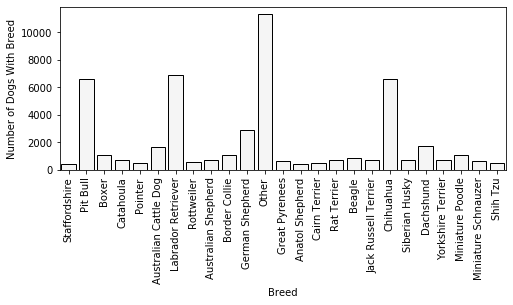

In [32]:
plt.figure(figsize=(8,3))
sns.barplot(x=dog_breeds.groupby('breed_category').count().index, 
            y=dog_breeds.groupby('breed_category').count()['breed_name'], 
            data=dog_breeds.groupby('breed_category').count(), color='whitesmoke', 
            order=sortgroup, ec='black')
plt.xlabel('Breed')
plt.ylabel('Number of Dogs With Breed')
plt.xticks(rotation=90)

In [33]:
breeds_list = dog_breeds['breed_category'].unique()
breeds_pval = ttest_all(breeds_list, dog_breeds, 'breed_category', 'time_in_shelter_days')
breeds_pval.sort_values('Mean', ascending=False, inplace=True)
breeds_pval

,Variable,Mean,Mean of Others,Test Statistic,p-value
24,Staffordshire,15.107768,9.163302,6.946155,1.513545e-11
18,Pit Bull,12.715471,9.160855,18.331808,2.925366e-73
7,Boxer,12.278256,9.163183,6.705829,3.196560e-11
9,Catahoula,11.803927,9.163364,4.609679,4.787602e-06
19,Pointer,11.174226,9.163458,3.446325,6.137114e-04
3,Australian Cattle Dog,10.999629,9.163234,5.514739,4.055356e-08
15,Labrador Retriever,10.335118,9.162645,7.006735,2.670570e-12
21,Rottweiler,10.260036,9.163511,1.786166,7.463123e-02
4,Australian Shepherd,9.499602,9.163553,0.711496,4.770141e-01
6,Border Collie,9.229497,9.163572,0.187146,8.515811e-01


In [34]:
breeds_pval[breeds_pval['p-value']<0.05]

,Variable,Mean,Mean of Others,Test Statistic,p-value
24,Staffordshire,15.107768,9.163302,6.946155,1.513545e-11
18,Pit Bull,12.715471,9.160855,18.331808,2.925366e-73
7,Boxer,12.278256,9.163183,6.705829,3.196560e-11
9,Catahoula,11.803927,9.163364,4.609679,4.787602e-06
19,Pointer,11.174226,9.163458,3.446325,6.137114e-04
3,Australian Cattle Dog,10.999629,9.163234,5.514739,4.055356e-08
15,Labrador Retriever,10.335118,9.162645,7.006735,2.670570e-12
1,Other,8.530873,9.164410,-5.774037,7.942686e-09
8,Cairn Terrier,7.960757,9.163649,-2.056427,4.026923e-02
20,Rat Terrier,7.933848,9.163680,-3.008030,2.724284e-03


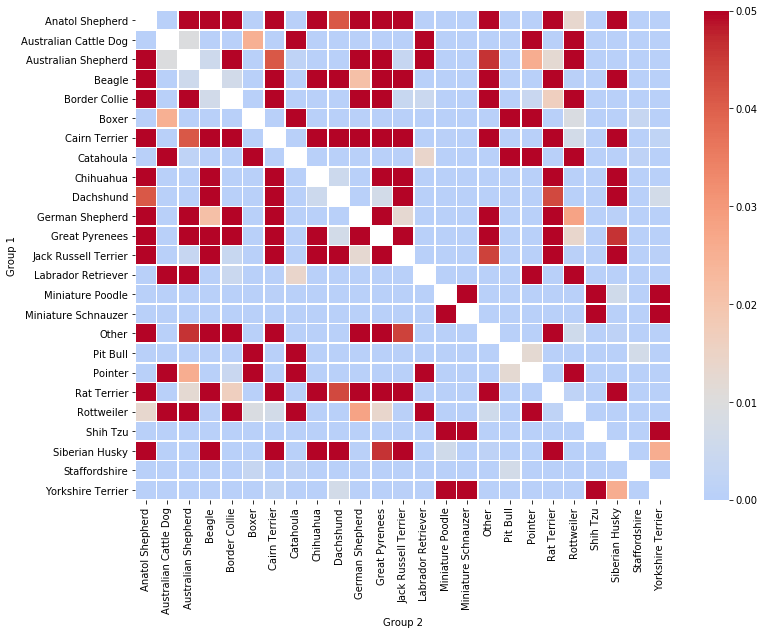

In [35]:
paired_breed_pval = pairwise_ttest(breeds_list, dog_breeds, 'breed_category', 'time_in_shelter_days', graph=False)
paired_breed_pval.drop(columns=[np.nan], inplace=True)
paired_breed_pval.drop([np.nan], inplace=True)

plt.figure(figsize=(12, 9))
ax = sns.heatmap(paired_breed_pval, cmap='coolwarm', vmax=0.05, center=0.01, linewidths=.5)

# Do certain breed groups have longer adoption times?

### AKC groupings include the Hound Group, Terrier Group, Working Group, Herding Group, Sporting Group, Non-Sporting Group, Toy Group, and Miscellaneous
Here, I pulled data from the [AKC](https://en.wikipedia.org/wiki/List_of_dog_breeds) to categorize dog breeds into breed groups. Breed groups have histories of being bred for similar functions and traits, and here, I've hypothesized that the Working Group has longer adoption times and may be less desirable for families. 

The AKC website describes Working breeds as follows:
> They were developed to assist humans in some capacity – including pulling sleds and carts, guarding flocks and homes, and protecting their families – and many of these breeds are still used as working dogs today. Breeds in the Working Group tend to be known for imposing stature, strength, and intelligence.

More information on AKC breed groupings can be found [here](https://www.akc.org/expert-advice/lifestyle/7-akc-dog-breed-groups-explained/).

In [36]:
dog_groups = pd.read_csv('dogbreed_categories.csv', header=0)
dog_groups = dog_groups[['Breed', 'Origin', 'American Kennel Club[4]', 'United Kennel Club[9]']]

In [37]:
breed_groups = pd.merge(left=dog_breeds, right=dog_groups, left_on='breed', right_on='Breed')
AKCgroups = ['Hound Group', 'Terrier Group', 'Working Group', 'Herding Group', 
             'Sporting Group', 'Non-Sporting Group', 'Toy Group', 'Miscellaneous']
breed_groups = breed_groups[breed_groups['American Kennel Club[4]'].isin(AKCgroups)]

In [38]:
sortbreedgroup = breed_groups.groupby('American Kennel Club[4]').mean().sort_values('time_in_shelter_days', ascending=False)
sortbreedgroup = sortbreedgroup['time_in_shelter_days'].to_dict()

## Miscellaneous breeds have the longest adoption times; however, there weren't many dogs falling into this category.
Only the Dogo Argentino and Dutch Shepherd were in this group, and only 56 dogs included these breeds.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

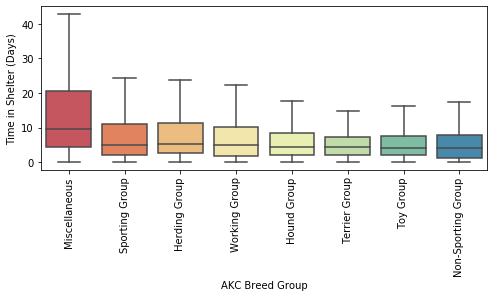

In [39]:
plt.figure(figsize=(8, 3))
sns.boxplot(x='American Kennel Club[4]', y='time_in_shelter_days', 
                    data=breed_groups, palette='Spectral', showfliers=False, order=sortbreedgroup)
plt.xlabel('AKC Breed Group')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

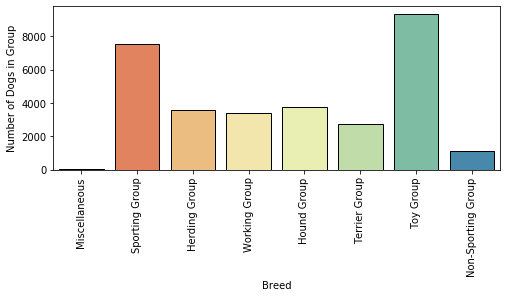

In [40]:
plt.figure(figsize=(8,3))
sns.barplot(x=breed_groups.groupby('American Kennel Club[4]').count().index, 
            y=breed_groups.groupby('American Kennel Club[4]').count()['breed_name'], 
            data=breed_groups.groupby('American Kennel Club[4]').count(), palette='Spectral', 
            order=sortbreedgroup, ec='black')
plt.xlabel('Breed')
plt.ylabel('Number of Dogs in Group')
plt.xticks(rotation=90)

In [41]:
breed_groups[breed_groups['American Kennel Club[4]']=='Miscellaneous'].count()

breed_list                 56
mixed_breed                56
time_in_shelter_days       56
breed_name                 56
has_breed                  56
breed                      56
breed_category             56
Breed                      56
Origin                     56
American Kennel Club[4]    56
United Kennel Club[9]      56
dtype: int64

In [42]:
groups_list = breed_groups['American Kennel Club[4]'].unique()
groups_pval = ttest_all(groups_list, breed_groups, 'American Kennel Club[4]', 'time_in_shelter_days')
groups_pval.sort_values('Mean', ascending=False, inplace=True)
groups_pval[groups_pval['p-value']<=0.05]

,Variable,Mean,Mean of Others,Test Statistic,p-value
7,Miscellaneous,14.261992,8.577419,3.150010,2.636775e-03
6,Sporting Group,10.068824,8.122124,11.240206,3.744017e-29
4,Herding Group,10.011626,8.405273,7.194260,7.347855e-13
3,Working Group,9.543208,8.472276,4.515450,6.497713e-06
1,Hound Group,7.947408,8.674574,-3.853628,1.177970e-04
2,Terrier Group,7.512534,8.690674,-5.459079,5.123967e-08
0,Toy Group,7.234608,9.157293,-14.374307,1.232790e-46
5,Non-Sporting Group,6.934897,8.646534,-5.644154,2.068306e-08


## Does Breed Group have an effect on adoption time when only commonly occurring breeds are considered?
Only dog breeds that occurred >400 times in the data were considered here.

In [43]:
breed_groups_common = pd.merge(left=dog_breeds, right=dog_groups, left_on='breed_category', right_on='Breed')
breed_groups_common = breed_groups_common[breed_groups_common['American Kennel Club[4]'].isin(AKCgroups)]

In [44]:
sortbreedgroup_common = breed_groups_common.groupby('American Kennel Club[4]').mean().sort_values('time_in_shelter_days', ascending=False)
sortbreedgroup_common = sortbreedgroup_common['time_in_shelter_days'].to_dict()

## Sporting, Herding, and Working groups seem to have longer adoption times than Terrier and Toy Groups.
Additionally, there were no commonly occuring breeds that fell into the Miscellaneous and Non-Sporting Group categories.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

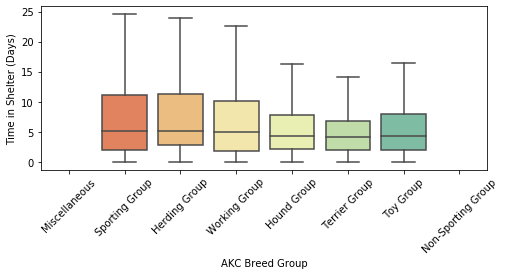

In [45]:
plt.figure(figsize=(8,3))
sns.boxplot(x='American Kennel Club[4]', y='time_in_shelter_days', 
                    data=breed_groups_common, palette='Spectral', showfliers=False, order=sortbreedgroup)
plt.xlabel('AKC Breed Group')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

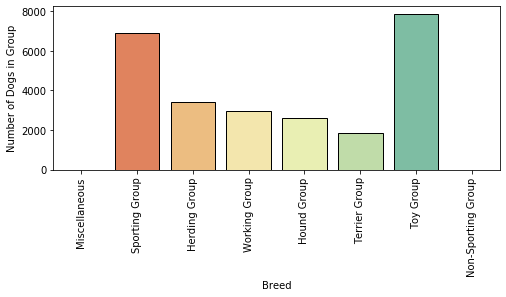

In [46]:
plt.figure(figsize=(8, 3))
sns.barplot(x=breed_groups_common.groupby('American Kennel Club[4]').count().index, 
            y=breed_groups_common.groupby('American Kennel Club[4]').count()['breed_name'], 
            data=breed_groups_common.groupby('American Kennel Club[4]').count(), palette='Spectral', 
            order=sortbreedgroup, ec='black')
plt.xlabel('Breed')
plt.ylabel('Number of Dogs in Group')
plt.xticks(rotation=90)

In [47]:
groups_list_common = breed_groups_common['American Kennel Club[4]'].unique()
groups_pval = ttest_all(groups_list_common, breed_groups_common, 'American Kennel Club[4]', 'time_in_shelter_days')
groups_pval.sort_values('Mean', ascending=False, inplace=True)
groups_pval

,Variable,Mean,Mean of Others,Test Statistic,p-value
5,Sporting Group,10.335118,8.205083,11.410549,5.573428e-30
0,Herding Group,10.126082,8.570117,6.710491,2.184613e-11
2,Working Group,9.881045,8.635109,4.716373,2.493283e-06
4,Toy Group,7.352234,9.411491,-13.749437,8.290704e-43
1,Hound Group,7.264945,8.949943,-8.107188,7.028177e-16
3,Terrier Group,6.910717,8.924551,-7.981845,2.265024e-15


# Mixed breeds are more likely to have longer adoption times than purebred dogs.

Text(0, 0.5, 'Time in Shelter (Days)')

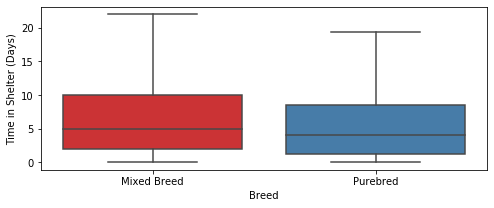

In [48]:
plt.figure(figsize=(8,3))
sns.boxplot(x='mixed_breed', y='time_in_shelter_days', 
                    data=dog_breeds, palette='Set1', showfliers=False)
plt.xlabel('Breed')
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Number of Dogs in Group')

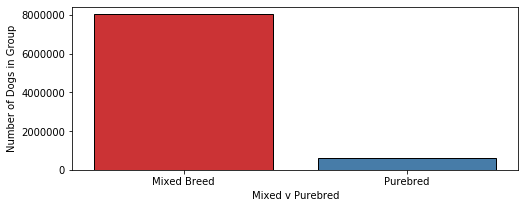

In [49]:
plt.figure(figsize=(8, 3))
sns.barplot(x=dog_breeds.groupby('mixed_breed').count().index, 
            y=dog_breeds.groupby('mixed_breed').count()['breed_name'], 
            data=dog_breeds.groupby('mixed_breed').count(), palette='Set1', 
            ec='black')
plt.xlabel('Mixed v Purebred')
plt.ylabel('Number of Dogs in Group')

In [50]:
mixed_breed = dog_breeds[dog_breeds['mixed_breed']=='Mixed Breed']
purebred = dog_breeds[dog_breeds['mixed_breed']=='Purebred']
np.mean(mixed_breed['time_in_shelter_days']), np.mean(purebred['time_in_shelter_days']), stats.ttest_ind(mixed_breed['time_in_shelter_days'], purebred['time_in_shelter_days'], equal_var=False)

(9.27300291185102,
 7.73363256182839,
 Ttest_indResult(statistic=102.16803908004813, pvalue=0.0))

# Do older dogs have a harder time getting adopted than puppies?
My hypothesis here is that puppies are adopted significantly faster than adult dogs.


<img src="https://www.thelabradorsite.com/wp-content/uploads/2018/05/introducing-puppy-to-older-dog-header-696x377.jpg" width=400px align="center"><br>
[Image Credit](https://www.thelabradorsite.com/introducing-puppy-to-older-dog/)

#### Age is not a continuous variable in this dataset. Even when analyzed by age in days, its rounded up to the year, making it difficult to analyze linearly.

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.,  8000.]), <a list of 10 Text xticklabel objects>)

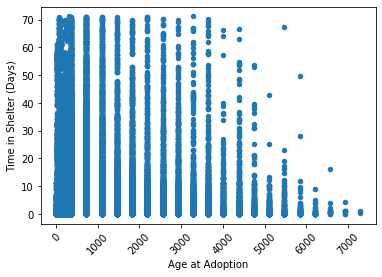

In [51]:
dogs.plot(x='age_upon_outcome_(days)', y='time_in_shelter_days', 
                    kind='scatter') #showfliers=True)
plt.xlabel('Age at Adoption')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

## Older dogs do not have longer adoption times overall; however, dogs <2.5 years old have a slight advantage over dogs between 2.5 - 5 years old.
Some of this effect may be due to fewer older animals in the shelter: there is less data for older dogs than for young ones.

In [52]:
dogs['age_group'] = dogs['age_upon_outcome_age_group'].str[1:-1]
dogs['age_group'] = dogs['age_group'].str.replace(', ','-')

Text(0, 0.5, 'Time in Shelter (Days)')

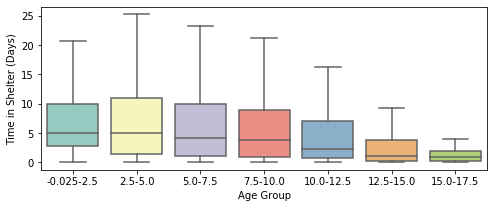

In [53]:
plt.figure(figsize=(8,3))
sns.boxplot(x='age_group', y='time_in_shelter_days', 
            data=dogs, palette='Set3', showfliers=False, 
            order=['-0.025-2.5', '2.5-5.0', '5.0-7.5',
                   '7.5-10.0', '10.0-12.5', '12.5-15.0',
                   '15.0-17.5'])
plt.xlabel('Age Group')
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Number of Dogs in Group')

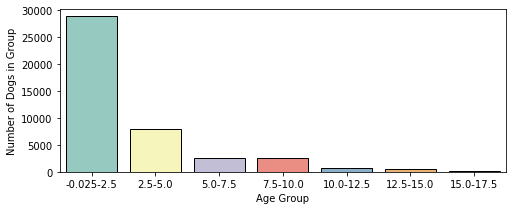

In [54]:
plt.figure(figsize=(8, 3))
sns.barplot(x=dogs.groupby('age_group').count().index, 
            y=dogs.groupby('age_group').count()['age_upon_outcome'], 
            data=dogs.groupby('age_group').count(), palette='Set3', 
            order=['-0.025-2.5', '2.5-5.0', '5.0-7.5',
                   '7.5-10.0', '10.0-12.5', '12.5-15.0',
                   '15.0-17.5'], ec='black')
plt.xlabel('Age Group')
plt.ylabel('Number of Dogs in Group')

In [55]:
age_groups = ['-0.025-2.5', '2.5-5.0', '5.0-7.5',
              '7.5-10.0', '10.0-12.5', '12.5-15.0', '15.0-17.5']
ttest_all(age_groups, dogs, 'age_group', 'time_in_shelter_days')

,Variable,Mean,Mean of Others,Test Statistic,p-value
0,-0.025-2.5,9.545986,8.403775,9.136148,6.861637e-20
1,2.5-5.0,9.329767,9.125962,1.310753,1.899665e-01
2,5.0-7.5,8.348343,9.214438,-3.477230,5.140958e-04
3,7.5-10.0,7.643754,9.258076,-6.785293,1.397142e-11
4,10.0-12.5,6.044202,9.216925,-8.569254,5.670880e-17
5,12.5-15.0,3.497436,9.238928,-19.243471,5.154736e-65
6,15.0-17.5,2.181098,9.180531,-12.335577,3.060507e-22


# Is Black Dog Syndrome occuring at the Austin Animal Shelter?
This phenomenon, described [here](https://en.wikipedia.org/wiki/Black_dog_syndrome), hypothesizes that black dogs are less likely to be adopted than lighter colored dogs. While this phenomenon is widely disputed, several efforts have been made to assist dark-coated dogs with adoption, including the [The Black Dog Project](https://www.fredlevyart.com/index/G00007N.NR0KFZ5I).

As with breed, many dogs had mixed coat colors: there are 337 coat color variations in this dataset. I addressed these the same way as breed, by separating mixed colors and analyzing them separately. 

However, dark colored dogs *do* make up 3 of the 4 most common coat colors: Black/White, Black, and Brown/White.

<img src="http://blog.fredlevyart.com/wp-content/uploads/2014/02/black_dogs-11.jpg" width=400px align="center"><br>
[Image Credit](http://blog.fredlevyart.com/photos/new-blog-black-dog-project)

In [56]:
dogs['color'].nunique()

335

In [57]:
dogs['color'].value_counts().head()

Black/White    4912
Black          2407
Tan/White      2333
Brown/White    2322
White          2300
Name: color, dtype: int64

In [218]:
dogs['coat_color_list'] = dogs['color'].str.split('/')
dogs.loc[dogs.coat_color_list.str.len()>1, 'multicolor'] = 'Multicolor'
dogs.loc[dogs['color'].str.contains('Tricolor'), 'multicolor'] = 'Multicolor'
dogs['multicolor'] = dogs['multicolor'].fillna('Single Color')

In [219]:
coat_colors = pd.get_dummies(dogs['coat_color_list'].apply(pd.Series).stack()).sum(level=0)

In [220]:
coat_colors_combined = pd.concat([dogs, coat_colors], axis=1)

In [221]:
coat1 = coat_colors_combined[['color', 'coat_color_list', 'multicolor', 'time_in_shelter_days']]
coat2 = coat_colors_combined.loc[:, 'Agouti':]
coat_melt = pd.concat([coat1, coat2], axis=1)
dog_coats = pd.melt(coat_melt, id_vars=['color', 'coat_color_list', 'multicolor','time_in_shelter_days'], 
                       var_name='coat_color', value_name='has_color')
dog_coats.loc[dog_coats['has_color']==1, 'colored'] = dog_coats['coat_color']

Similarly to breed, I grouped all colors that occur <200 times into an "other colors" group.

In [222]:
common_colors = dog_coats.groupby('colored').count()
common_colors = common_colors.sort_values('has_color', ascending=False)
other_colors = common_colors.loc[common_colors['has_color']<200,:]
other_colors_list = other_colors.index.tolist()

In [223]:
dog_coats.loc[dog_coats['colored'].isin(other_colors_list), 'color_category'] = 'Other'
dog_coats.loc[~dog_coats['colored'].isin(other_colors_list), 'color_category'] = dog_coats['colored']

In [224]:
sort_color = dog_coats.groupby('color_category').mean().sort_values('time_in_shelter_days', ascending=False)
sort_color = sort_color['time_in_shelter_days'].to_dict()

## While there were some dark colored dogs that had longer adoption times, there wasn't an obvious pattern here.

Black Brindle is shown below. <br>
<img src="https://cdn.shortpixel.ai/spai/w_1600+q_lossless+ret_img/https://www.k9ofmine.com/wp-content/uploads/2017/03/brindle-dog-breeds.jpg" width=400px align="center"/><br>
[Image Credit](https://www.k9ofmine.com/brindle-dog-breeds/)<br>


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

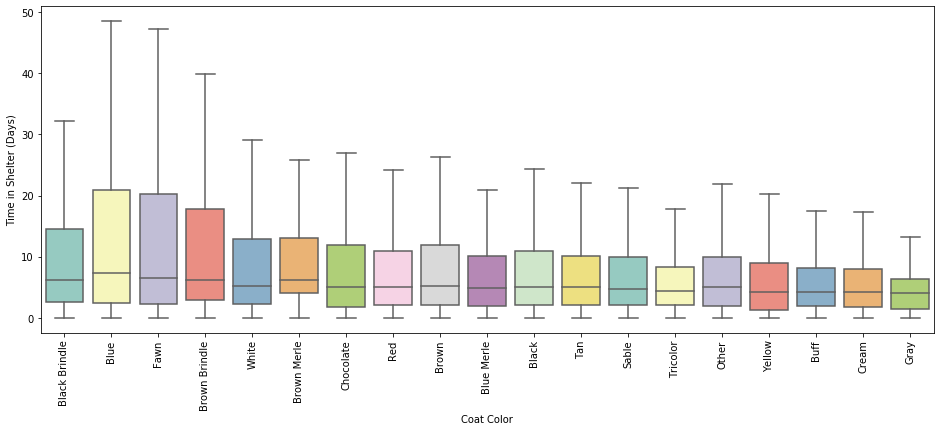

In [225]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='color_category', y='time_in_shelter_days', 
                    data=dog_coats, palette='Set3', showfliers=False, order=sort_color)
plt.xlabel('Coat Color')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

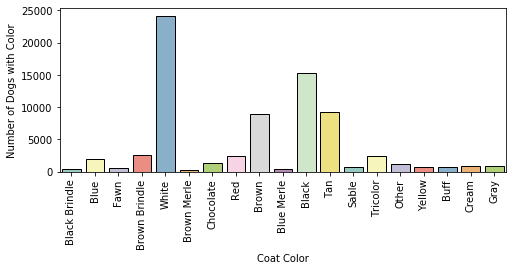

In [226]:
plt.figure(figsize=(8, 3))
sns.barplot(x=dog_coats.groupby('color_category').count().index, 
            y=dog_coats.groupby('color_category').count()['color'], 
            data=dog_coats.groupby('color_category').count(), palette='Set3', 
            order=sort_color, ec='black')
plt.xlabel('Coat Color')
plt.ylabel('Number of Dogs with Color')
plt.xticks(rotation=90)

In [227]:
color_list = dog_coats['color_category'].unique()
pval = ttest_all(color_list, dog_coats, 'color_category', 'time_in_shelter_days')
pval[pval['p-value']<0.05]

,Variable,Mean,Mean of Others,Test Statistic,p-value
1,Other,11.821873,15.899887,-5.264837,1.665942e-07
2,Black,15.091587,15.904076,-2.366504,1.796915e-02
3,Black Brindle,24.356143,15.895726,2.379908,1.789513e-02
4,Blue,23.433774,15.889363,6.572418,6.377972e-11
7,Brown Brindle,21.555090,15.889133,6.239135,5.119452e-10
9,Buff,9.537047,15.899577,-8.721474,2.172233e-17
11,Cream,9.436684,15.900262,-8.921805,2.770337e-18
12,Fawn,22.962681,15.894944,3.470916,5.566369e-04
13,Gray,9.083962,15.900427,-7.039259,3.987135e-12
15,Sable,12.549681,15.898617,-2.254955,2.442579e-02


## Being multicolor versus single colored seems to have almost no affect on adoption time.

Text(0, 0.5, 'Time in Shelter (Days)')

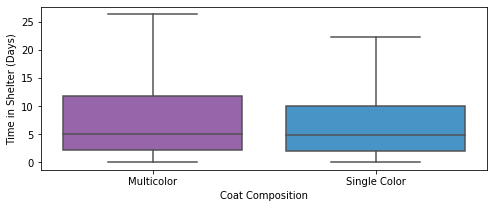

In [228]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
plt.figure(figsize=(8, 3))
sns.boxplot(x='multicolor', y='time_in_shelter_days',
                    data=dog_coats, palette=flatui, showfliers=False)
plt.xlabel('Coat Composition')
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Number of Dogs')

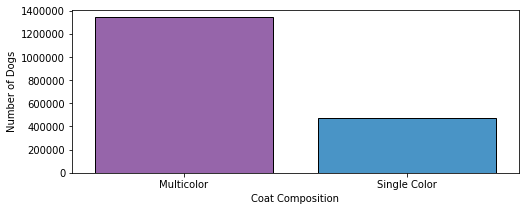

In [229]:
plt.figure(figsize=(8, 3))
sns.barplot(x=dog_coats.groupby('multicolor').count().index, 
            y=dog_coats.groupby('multicolor').count()['color'], 
            data=dog_coats.groupby('multicolor').count(), palette=flatui, 
            ec='black')
plt.xlabel('Coat Composition')
plt.ylabel('Number of Dogs')

In [260]:
multicolor = dog_coats.loc[dog_coats['multicolor']=='Multicolor', 'time_in_shelter_days']
singlecolor = dog_coats.loc[dog_coats['multicolor']=='Single Color', 'time_in_shelter_days']
np.mean(multicolor), np.mean(singlecolor), stats.ttest_ind(multicolor, singlecolor)

(16.742531945442497,
 13.507552947434684,
 Ttest_indResult(statistic=43.11361834666819, pvalue=0.0))

In [265]:
type(multicolor)

numpy.ndarray

In [268]:
#manual t-test calculation - are the numbers going in making sense?
from scipy.stats import t
x1 = np.mean(multicolor)
x0 = np.mean(singlecolor)

s1 = np.std(multicolor)
s0 = np.std(singlecolor)

n1 = len(multicolor)
n0 = len(singlecolor)

sp = np.sqrt( ((n0 - 1) * s0**2 + (n1 - 1) * s1**2) / ( n0 + n1 - 2) )
t_stat = ( x0 - x1 ) / ( sp * np.sqrt( 1/n0 + 1/n1 ) )

total_dof = n0 + n1 - 2
p_value = 2 * t.cdf(t_stat, df=total_dof)

t_stat, p_value


(-43.11364025092397, 0.0)

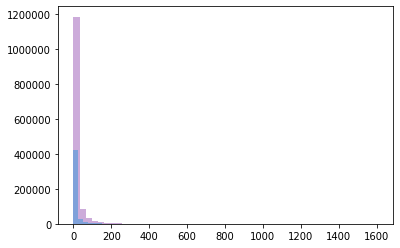

In [236]:
_ = plt.hist(multicolor, alpha=0.5, bins=50)
_ = plt.hist(singlecolor, alpha=0.5, bins=50)

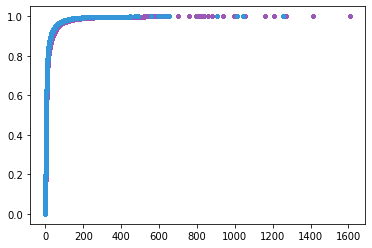

In [237]:
xm, ym = ecdf(multicolor)
xs, ys = ecdf(singlecolor)
_ = plt.plot(xm, ym, marker='.', linestyle='None')
_ = plt.plot(xs, ys, marker='.', linestyle='None')

In [238]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(multicolor) - np.mean(singlecolor)

# Get bootstrap replicates of means
bs_replicates_multicolor = draw_bs_reps(multicolor, np.mean, size=10000)
bs_replicates_singlecolor = draw_bs_reps(singlecolor, np.mean, size=10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_multicolor - bs_replicates_singlecolor

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])
print('Mean Difference: ' + str(mean_diff) + ', CI: ' + str(conf_int))

Mean Difference: 3.234978998007813, CI: [3.10169552 3.37106348]


In [239]:
np.mean(multicolor) - combined_mean

7.578951502771401

In [240]:
multi_shifted

3           4.705022
5           0.605716
13         10.620994
19         22.839744
20         -0.235951
22         -0.088034
23          3.934188
27         -0.208867
30         -0.197062
33          0.618911
37          6.443911
38          2.490438
39          0.072383
47         -0.199839
49         -0.078312
53          7.673772
56         -0.185951
58          3.876549
59          2.599466
60         10.786966
62          0.018911
64          4.731411
66          0.193216
70          1.966827
73          0.027244
80          9.764049
85         -0.152617
87         -0.195673
88          0.868216
89          1.284188
             ...    
1734160     1.593911
1734168     6.873077
1734171     5.840438
1734172     4.880716
1734175     8.886272
1734187     0.453633
1734188     4.802244
1734189    -0.165117
1734205     4.588355
1734208     7.115438
1734211     3.998077
1734223     4.821688
1734230    -0.125534
1734243     6.742522
1734263     0.718911
1734264     3.889744
1734269     7

In [241]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(multicolor) - np.mean(singlecolor)

# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate([multicolor, singlecolor]))

# Shift the samples
multi_shifted = multicolor - np.mean(multicolor) + combined_mean
single_shifted = singlecolor - np.mean(singlecolor) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_multi_shifted = draw_bs_reps(multi_shifted, np.mean, 10000)
bs_replicates_single_shifted = draw_bs_reps(single_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates_shifted = bs_replicates_multi_shifted - bs_replicates_single_shifted

# Compute the p-value: p
p = np.sum(np.abs(bs_diff_replicates_shifted) >= mean_diff) / len(bs_diff_replicates_shifted)

# Print p-value
print('p =', p)
combined_mean

p = 0.0


15.897241616947584

In [242]:
p

0.0

In [243]:
bs_diff_replicates_shifted

array([ 0.03156487, -0.02802318,  0.02077309, ...,  0.0458689 ,
        0.05788169,  0.08104294])

In [244]:
mean_diff

3.234978998007813

In [245]:
combined_mean

15.897241616947584

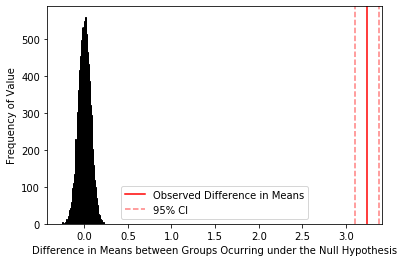

In [246]:
_ = plt.hist(bs_diff_replicates_shifted, bins=50, ec='black')
_ = plt.xlabel('Difference in Means between Groups Ocurring under the Null Hypothesis')
_ = plt.ylabel('Frequency of Value')
_ = plt.axvline(mean_diff, c='red')
_ = plt.axvline(conf_int[0], linestyle='--', c='red', alpha=0.5)
_ = plt.axvline(conf_int[1], linestyle='--', c='red', alpha=0.5)
_ = plt.legend(['Observed Difference in Means','95% CI'])

In [247]:
np.median(multicolor), np.mean(multicolor)

(5.110416666666667, 16.742531945442497)

In [248]:
np.median(singlecolor), np.mean(singlecolor)

(4.906597222222222, 13.507552947434684)

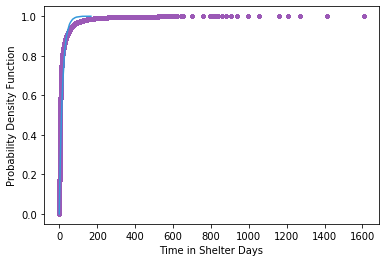

In [249]:
mean = np.mean(multicolor)
samples = np.random.exponential(mean, size=10000)
x, y = ecdf(multicolor)
x_theor, y_theor = ecdf(samples)

_ = plt.plot(x, y, marker='.', linestyle='None')
_ = plt.plot(x_theor, y_theor)
_ = plt.ylabel('Probability Density Function')
_ = plt.xlabel('Time in Shelter Days')

In [79]:
#analysis of all data, without outliers excluded

***
# A closer look at man's best friend
What puts a dog at a higher risk of having a long adoption time?

<img src="http://wholesolutionsgroup.com/wp-content/uploads/2016/08/Man-and-Dog--1080x675.jpg" width=400px align=center><br>
[Image Credit](http://wholesolutionsgroup.com/why-dogs-are-mans-best-friend/)

## Does dog breed affect adoption time?
In this section, I hypothesized that stereotypically common shelter breeds, such as ***Pit Bulls and Chihuahuas***,  have longer adoption times than other breeds. 

<img src="https://assets3.thrillist.com/v1/image/2775369/size/tmg-article_tall.jpg" width=400px align="center"><br>
[Image Credit](https://www.thedodo.com/close-to-home/pit-bull-dog-carries-chihuahua-friend)

In [80]:
dogs = df[df['animal_type'] == 'Dog']
cats = df[df['animal_type'] == 'Cat']
birds = df[df['animal_type'] == 'Bird']
other = df[df['animal_type'] == 'Other']

### Pit bulls and chihuahuas do represent the most common breeds at this shelter.

In [81]:
dogs['breed'].value_counts().head()

Pit Bull Mix                 6256
Chihuahua Shorthair Mix      4831
Labrador Retriever Mix       4789
German Shepherd Mix          1950
Australian Cattle Dog Mix    1099
Name: breed, dtype: int64

Because many of the animals at this shelter were categorized as mixed breeds, it became impossible to see patterns by breed - there were 1919 unique breed categorizations. To simplify this analysis, I sorted the data such that each breed is a unique column, and each animal has a 1 or 0 based on whether it is in part or full that breed. I further created a mixed breed/purebred column to later analyze whether purebreds are adopted more quickly than mixed breeds.

In [82]:
dogs['breed'].nunique()

1919

In [83]:
dogs['breed'] = dogs['breed'].str.replace('Black/Tan Hound', 'Black-Tan Hound')
dogs['breed'] = dogs['breed'].str.replace(' Shorthair', '')
dogs['breed'] = dogs['breed'].str.replace(' Longhair', '')
dogs['breed_nomix'] = dogs['breed'].str.replace(' Mix', '')
dogs['breed_list'] = dogs['breed_nomix'].str.split('/')
dogs.loc[dogs.breed_list.str.len()>1, 'mixed_breed'] = 'Mixed Breed'
dogs.loc[dogs['breed'].str.contains('Mix'), 'mixed_breed'] = 'Mixed Breed'
dogs['mixed_breed'] = dogs['mixed_breed'].fillna('Purebred')
#dogs.sort_index(axis=0)

In [84]:
has_breeds = pd.get_dummies(dogs['breed_list'].apply(pd.Series).stack()).sum(level=0)

In [85]:
dog_breeds_combined = pd.concat([dogs, has_breeds], axis=1)

In [86]:
breed_melt1 = dog_breeds_combined[['breed_list', 'mixed_breed', 'time_in_shelter_days']]
breed_melt2 = dog_breeds_combined.loc[:, 'Affenpinscher':]
breed_melt = pd.concat([breed_melt1, breed_melt2], axis=1)
dog_breeds = pd.melt(breed_melt, id_vars=['breed_list','mixed_breed','time_in_shelter_days'], 
                       var_name='breed_name', value_name='has_breed')
dog_breeds.loc[dog_breeds['has_breed']==1, 'breed'] = dog_breeds['breed_name']

#### I grouped dog breeds that occur <400 times into a group called "other" to see only the most common breeds.

In [87]:
common_breeds = dog_breeds.groupby('breed').sum()
common_breeds = common_breeds.sort_values('has_breed', ascending=False)
other_breeds = common_breeds.loc[common_breeds['has_breed']<400,:]
other_breeds_list = other_breeds.index.tolist()

In [88]:
dog_breeds.loc[dog_breeds['breed'].isin(other_breeds_list), 'breed_category'] = 'Other'
dog_breeds.loc[~dog_breeds['breed'].isin(other_breeds_list), 'breed_category'] = dog_breeds['breed']

In [89]:
sortgroup = dog_breeds.groupby('breed_category').mean().sort_values('time_in_shelter_days', ascending=False)
sortgroup = sortgroup['time_in_shelter_days'].to_dict()

## American Bull Dogs and Staffordshires beat out Pit Bulls with the longest adoption times.
### Additionally, Chihuahuas are fairly far down the list.

Interestingly, purebred Pit Bulls had ***longer*** adoption times than mixed breed Pit Bulls, perhaps due to prevalent stereotypes about this breed. The same applied to Staffordshires; however, most other breeds had faster adoption times in purebreds.
The graph below is sorted L-R by mean adoption times.

<img src="https://i0.wp.com/puppytoob.com/wp-content/uploads/2017/04/American-bulldog-640x427.jpg?resize=640%2C427&ssl=1" width=400px align="center"><br>
[Image Credit](https://puppytoob.com/7-important-tips-taking-care-american-bulldog/)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

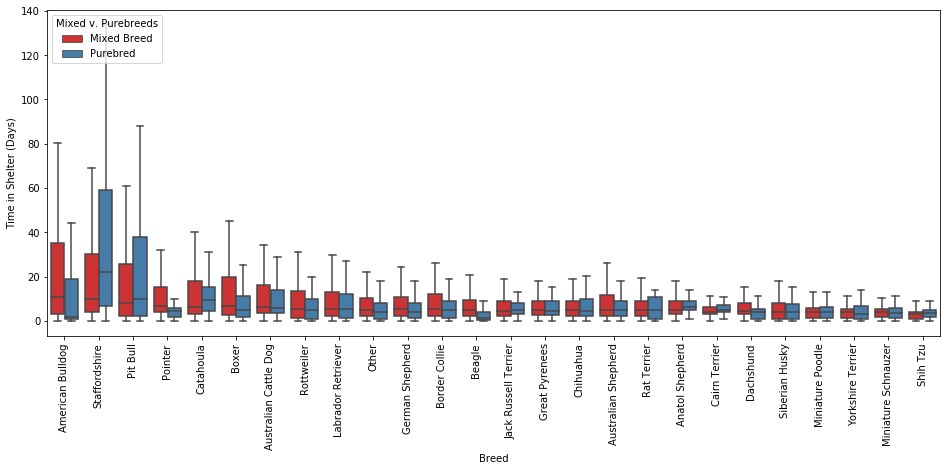

In [90]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='breed_category', y='time_in_shelter_days', hue='mixed_breed', 
                    data=dog_breeds, palette='Set1', showfliers=False, order=sortgroup)
plt.xlabel('Breed')
plt.ylabel('Time in Shelter (Days)')
plt.legend(title='Mixed v. Purebreeds', loc='upper left')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

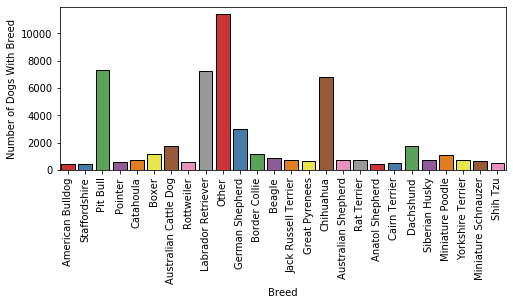

In [91]:
plt.figure(figsize=(8,3))
sns.barplot(x=dog_breeds.groupby('breed_category').count().index, 
            y=dog_breeds.groupby('breed_category').count()['breed_name'], 
            data=dog_breeds.groupby('breed_category').count(), palette='Set1', 
            order=sortgroup, ec='black')
plt.xlabel('Breed')
plt.ylabel('Number of Dogs With Breed')
plt.xticks(rotation=90)

In [92]:
breeds_list = dog_breeds['breed_category'].unique()
breeds_pval = ttest_all(breeds_list, dog_breeds, 'breed_category', 'time_in_shelter_days')

In [93]:
breeds_pval.sort_values('p-value', ascending=True, inplace=True)
breeds_pval[breeds_pval['Mean']<breeds_pval['Mean of Others']]

,Variable,Mean,Mean of Others,Test Statistic,p-value
18,Miniature Schnauzer,5.624449,15.897993,-26.039815,1.378725e-103
23,Shih Tzu,5.034102,15.897839,-24.115684,9.182533e-86
17,Miniature Poodle,7.337833,15.898283,-13.086213,1.754198e-36
26,Yorkshire Terrier,7.259027,15.897932,-10.959248,5.759267e-26
11,Chihuahua,11.433447,15.900586,-9.792643,1.704041e-22
24,Siberian Husky,8.961000,15.897781,-9.893112,1.070435e-21
12,Dachshund,9.289969,15.898534,-8.275646,2.479814e-16
9,Cairn Terrier,9.550129,15.897592,-8.040639,6.503340e-15
5,Australian Shepherd,11.380470,15.897597,-6.152310,1.273072e-09
1,Other,14.011654,15.899610,-4.973086,6.685396e-07


In [94]:
breeds_pval[breeds_pval['Mean']>=breeds_pval['Mean of Others']]

,Variable,Mean,Mean of Others,Test Statistic,p-value
19,Pit Bull,27.536659,15.887819,16.030080,7.208971e-57
25,Staffordshire,28.372662,15.896619,5.431543,9.142880e-08
2,American Bulldog,38.605701,15.896205,5.134122,4.374898e-07
4,Australian Cattle Dog,20.083315,15.896441,3.520411,4.420046e-04
8,Boxer,21.395662,15.896536,3.415416,6.588175e-04
10,Catahoula,22.543741,15.896690,3.207956,1.393463e-03
20,Pointer,22.587231,15.896826,2.940446,3.412274e-03
16,Labrador Retriever,17.024406,15.896345,2.089801,3.667057e-02
22,Rottweiler,17.809853,15.897122,0.879219,3.796552e-01


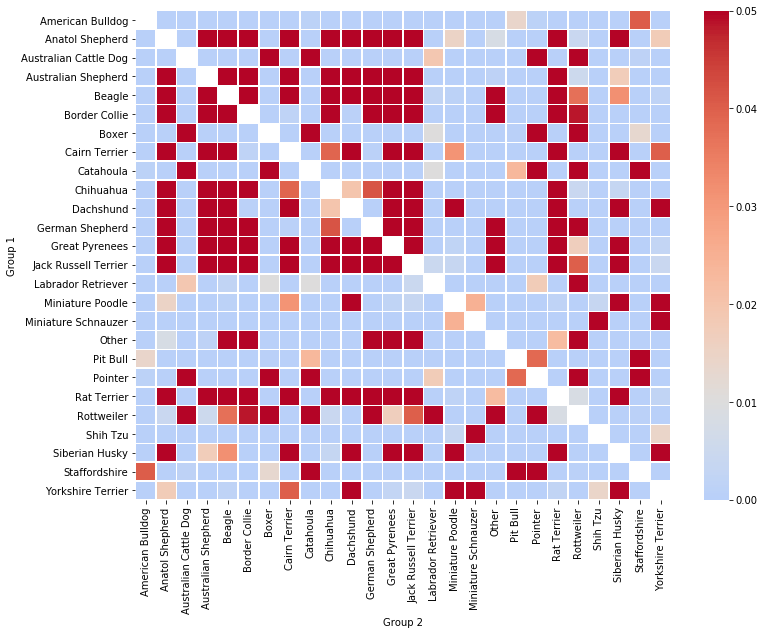

In [95]:
paired_breed_pval = pairwise_ttest(breeds_list, dog_breeds, 'breed_category', 'time_in_shelter_days', graph=False)
paired_breed_pval.drop(columns=[np.nan], inplace=True)
paired_breed_pval.drop([np.nan], inplace=True)

plt.figure(figsize=(12, 9))
ax = sns.heatmap(paired_breed_pval, cmap='coolwarm', vmax=0.05, center=0.01, linewidths=.5)

# Do certain breed groups have longer adoption times?

### AKC groupings include the Hound Group, Terrier Group, Working Group, Herding Group, Sporting Group, Non-Sporting Group, Toy Group, and Miscellaneous
Here, I pulled data from the [AKC](https://en.wikipedia.org/wiki/List_of_dog_breeds) to categorize dog breeds into breed groups. Breed groups have histories of being bred for similar functions and traits, and here, I've hypothesized that the Working Group has longer adoption times and may be less desirable for families. 

The AKC website describes Working breeds as follows:
> They were developed to assist humans in some capacity – including pulling sleds and carts, guarding flocks and homes, and protecting their families – and many of these breeds are still used as working dogs today. Breeds in the Working Group tend to be known for imposing stature, strength, and intelligence.

More information on AKC breed groupings can be found [here](https://www.akc.org/expert-advice/lifestyle/7-akc-dog-breed-groups-explained/).

In [96]:
dog_groups = pd.read_csv('dogbreed_categories.csv', header=0)
dog_groups = dog_groups[['Breed', 'Origin', 'American Kennel Club[4]', 'United Kennel Club[9]']]

In [97]:
breed_groups = pd.merge(left=dog_breeds, right=dog_groups, left_on='breed', right_on='Breed')
AKCgroups = ['Hound Group', 'Terrier Group', 'Working Group', 'Herding Group', 
             'Sporting Group', 'Non-Sporting Group', 'Toy Group', 'Miscellaneous']
breed_groups = breed_groups[breed_groups['American Kennel Club[4]'].isin(AKCgroups)]

In [98]:
sortbreedgroup = breed_groups.groupby('American Kennel Club[4]').mean().sort_values('time_in_shelter_days', ascending=False)
sortbreedgroup = sortbreedgroup['time_in_shelter_days'].to_dict()

## Miscellaneous breeds have the longest adoption times; however, there weren't many dogs falling into this category.
Only the Dogo Argentino and Dutch Shepherd were in this group, and there weren't many to pass through the ACC -  only 7 total.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

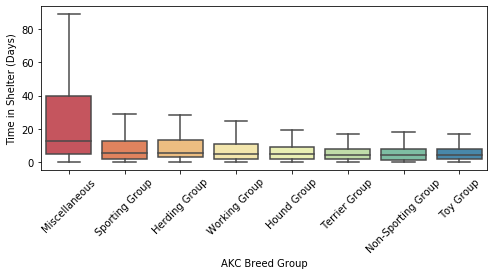

In [99]:
plt.figure(figsize=(8, 3))
sns.boxplot(x='American Kennel Club[4]', y='time_in_shelter_days', 
                    data=breed_groups, palette='Spectral', showfliers=False, order=sortbreedgroup)
plt.xlabel('AKC Breed Group')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

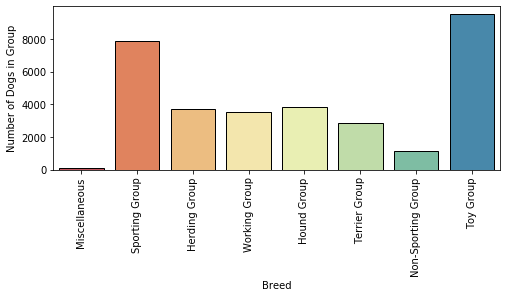

In [100]:
plt.figure(figsize=(8,3))
sns.barplot(x=breed_groups.groupby('American Kennel Club[4]').count().index, 
            y=breed_groups.groupby('American Kennel Club[4]').count()['breed_name'], 
            data=breed_groups.groupby('American Kennel Club[4]').count(), palette='Spectral', 
            order=sortbreedgroup, ec='black')
plt.xlabel('Breed')
plt.ylabel('Number of Dogs in Group')
plt.xticks(rotation=90)

In [101]:
groups_list = breed_groups['American Kennel Club[4]'].unique()
groups_pval = ttest_all(groups_list, breed_groups, 'American Kennel Club[4]', 'time_in_shelter_days')
groups_pval.sort_values('Mean', ascending=False, inplace=True)
groups_pval[groups_pval['p-value']<=0.05]

,Variable,Mean,Mean of Others,Test Statistic,p-value
7,Miscellaneous,41.099124,13.370842,3.398780,1.135026e-03
6,Sporting Group,16.493168,12.451453,7.309955,2.849308e-13
4,Herding Group,16.003839,13.095821,4.291052,1.813722e-05
3,Working Group,15.509506,13.177085,3.081016,2.076215e-03
2,Terrier Group,11.423397,13.621718,-3.769046,1.662521e-04
5,Non-Sporting Group,10.987093,13.516030,-2.301250,2.154751e-02
0,Toy Group,10.279935,14.731989,-10.257059,1.252982e-24


## Does Breed Group have an effect on adoption time when only commonly occurring breeds are considered?
Only dog breeds that occurred >400 times in the data were considered here.

In [102]:
breed_groups_common = pd.merge(left=dog_breeds, right=dog_groups, left_on='breed_category', right_on='Breed')
breed_groups_common = breed_groups_common[breed_groups_common['American Kennel Club[4]'].isin(AKCgroups)]

In [103]:
sortbreedgroup_common = breed_groups_common.groupby('American Kennel Club[4]').mean().sort_values('time_in_shelter_days', ascending=False)
sortbreedgroup_common = sortbreedgroup_common['time_in_shelter_days'].to_dict()

## Sporting, Herding, and Working groups seem to have longer adoption times than Terrier and Toy Groups.
Additionally, there were no commonly occuring breeds that fell into the Miscellaneous and Non-Sporting Group categories.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

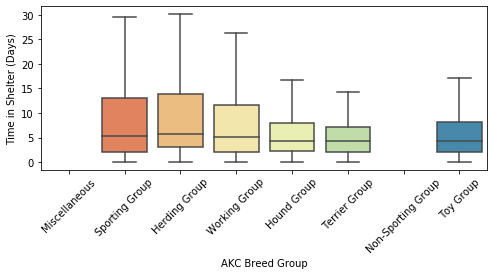

In [104]:
plt.figure(figsize=(8,3))
sns.boxplot(x='American Kennel Club[4]', y='time_in_shelter_days', 
                    data=breed_groups_common, palette='Spectral', showfliers=False, order=sortbreedgroup)
plt.xlabel('AKC Breed Group')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

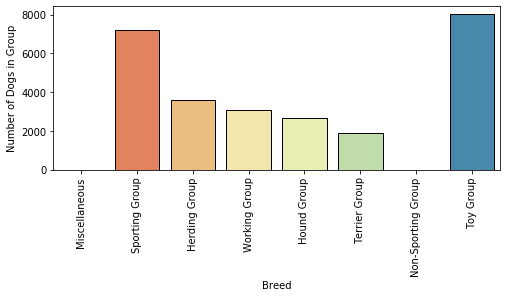

In [105]:
plt.figure(figsize=(8, 3))
sns.barplot(x=breed_groups_common.groupby('American Kennel Club[4]').count().index, 
            y=breed_groups_common.groupby('American Kennel Club[4]').count()['breed_name'], 
            data=breed_groups_common.groupby('American Kennel Club[4]').count(), palette='Spectral', 
            order=sortbreedgroup, ec='black')
plt.xlabel('Breed')
plt.ylabel('Number of Dogs in Group')
plt.xticks(rotation=90)

In [106]:
groups_list_common = breed_groups_common['American Kennel Club[4]'].unique()
groups_pval = ttest_all(groups_list_common, breed_groups_common, 'American Kennel Club[4]', 'time_in_shelter_days')
groups_pval.sort_values('Mean', ascending=False, inplace=True)
groups_pval

,Variable,Mean,Mean of Others,Test Statistic,p-value
5,Sporting Group,17.024406,12.298652,7.854428,4.393012e-15
0,Herding Group,16.166754,13.185002,4.216152,2.530799e-05
2,Working Group,15.898071,13.286885,3.110686,1.880706e-03
4,Toy Group,10.657533,14.869251,-8.457037,2.953924e-17
1,Hound Group,10.301881,13.954891,-4.818167,1.512785e-06
3,Terrier Group,8.851563,13.953252,-9.214135,5.666786e-20


# Mixed breeds are more likely to have longer adoption times than purebred dogs.

Text(0, 0.5, 'Time in Shelter (Days)')

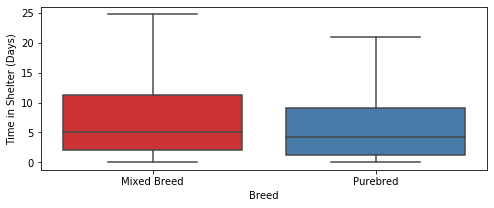

In [107]:
plt.figure(figsize=(8,3))
sns.boxplot(x='mixed_breed', y='time_in_shelter_days', 
                    data=dog_breeds, palette='Set1', showfliers=False)
plt.xlabel('Breed')
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Number of Dogs in Group')

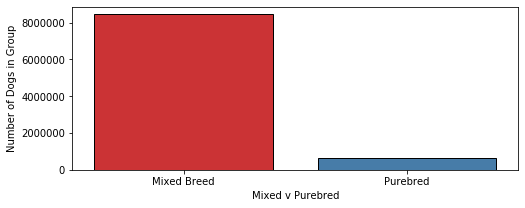

In [108]:
plt.figure(figsize=(8, 3))
sns.barplot(x=dog_breeds.groupby('mixed_breed').count().index, 
            y=dog_breeds.groupby('mixed_breed').count()['breed_name'], 
            data=dog_breeds.groupby('mixed_breed').count(), palette='Set1', 
            ec='black')
plt.xlabel('Mixed v Purebred')
plt.ylabel('Number of Dogs in Group')

# Do older dogs have a harder time getting adopted than puppies?
My hypothesis here is that puppies are adopted significantly faster than adult dogs.


<img src="https://www.thelabradorsite.com/wp-content/uploads/2018/05/introducing-puppy-to-older-dog-header-696x377.jpg" width=400px align="center"><br>
[Image Credit](https://www.thelabradorsite.com/introducing-puppy-to-older-dog/)

#### Age is not a continuous variable in this dataset. Even when analyzed by age in days, its rounded up to the year, making it difficult to analyze linearly.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.,  8000.]), <a list of 10 Text xticklabel objects>)

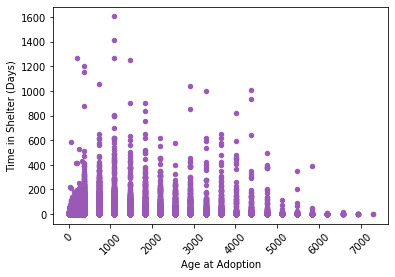

In [109]:
dogs.plot(x='age_upon_outcome_(days)', y='time_in_shelter_days', 
                    kind='scatter') #showfliers=True)
plt.xlabel('Age at Adoption')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

## Older dogs do not have longer adoption times overall; however, dogs <2.5 years old have a slight advantage over dogs between 2.5 - 5 years old.
Some of this effect may be due to fewer older animals in the shelter: there is less data for older dogs than for young ones.

In [110]:
dogs['age_group'] = dogs['age_upon_outcome_age_group'].str[1:-1]
dogs['age_group'] = dogs['age_group'].str.replace(', ','-')

Text(0, 0.5, 'Time in Shelter (Days)')

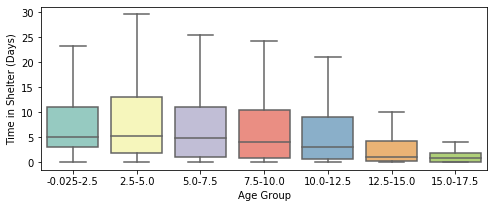

In [111]:
plt.figure(figsize=(8,3))
sns.boxplot(x='age_group', y='time_in_shelter_days', 
            data=dogs, palette='Set3', showfliers=False, 
            order=['-0.025-2.5', '2.5-5.0', '5.0-7.5',
                   '7.5-10.0', '10.0-12.5', '12.5-15.0',
                   '15.0-17.5'])
plt.xlabel('Age Group')
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Number of Dogs in Group')

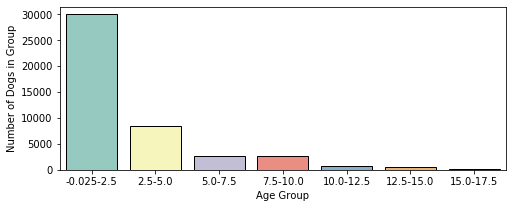

In [112]:
plt.figure(figsize=(8, 3))
sns.barplot(x=dogs.groupby('age_group').count().index, 
            y=dogs.groupby('age_group').count()['age_upon_outcome'], 
            data=dogs.groupby('age_group').count(), palette='Set3', 
            order=['-0.025-2.5', '2.5-5.0', '5.0-7.5',
                   '7.5-10.0', '10.0-12.5', '12.5-15.0',
                   '15.0-17.5'], ec='black')
plt.xlabel('Age Group')
plt.ylabel('Number of Dogs in Group')

# Is Black Dog Syndrome occuring at the Austin Animal Shelter?
This phenomenon, described [here](https://en.wikipedia.org/wiki/Black_dog_syndrome), hypothesizes that black dogs are less likely to be adopted than lighter colored dogs. While this phenomenon is widely disputed, several efforts have been made to assist dark-coated dogs with adoption, including the [The Black Dog Project](https://www.fredlevyart.com/index/G00007N.NR0KFZ5I).

As with breed, many dogs had mixed coat colors: there are 337 coat color variations in this dataset. I addressed these the same way as breed, by separating mixed colors and analyzing them separately. 

However, dark colored dogs *do* make up 3 of the 4 most common coat colors: Black/White, Black, and Brown/White.

<img src="http://blog.fredlevyart.com/wp-content/uploads/2014/02/black_dogs-11.jpg" width=400px align="center"><br>
[Image Credit](http://blog.fredlevyart.com/photos/new-blog-black-dog-project)

In [113]:
dogs['color'].nunique()

337

In [114]:
dogs['color'].value_counts().head()

Black/White    5201
Black          2507
Brown/White    2463
Tan/White      2450
White          2366
Name: color, dtype: int64

In [115]:
dogs['coat_color_list'] = dogs['color'].str.split('/')
dogs.loc[dogs.coat_color_list.str.len()>1, 'multicolor'] = 'Multicolor'
dogs.loc[dogs['color'].str.contains('Tricolor'), 'multicolor'] = 'Multicolor'
dogs['multicolor'] = dogs['multicolor'].fillna('Single Color')

In [116]:
coat_colors = pd.get_dummies(dogs['coat_color_list'].apply(pd.Series).stack()).sum(level=0)

In [117]:
coat_colors_combined = pd.concat([dogs, coat_colors], axis=1)

In [118]:
coat1 = coat_colors_combined[['color', 'coat_color_list', 'multicolor', 'time_in_shelter_days']]
coat2 = coat_colors_combined.loc[:, 'Agouti':]
coat_melt = pd.concat([coat1, coat2], axis=1)
dog_coats = pd.melt(coat_melt, id_vars=['color', 'coat_color_list', 'multicolor','time_in_shelter_days'], 
                       var_name='coat_color', value_name='has_color')
dog_coats.loc[dog_coats['has_color']==1, 'colored'] = dog_coats['coat_color']

Similarly to breed, I grouped all colors that occur <200 times into an "other colors" group.

In [119]:
common_colors = dog_coats.groupby('colored').count()
common_colors = common_colors.sort_values('has_color', ascending=False)
other_colors = common_colors.loc[common_colors['has_color']<200,:]
other_colors_list = other_colors.index.tolist()

In [120]:
dog_coats.loc[dog_coats['colored'].isin(other_colors_list), 'color_category'] = 'Other'
dog_coats.loc[~dog_coats['colored'].isin(other_colors_list), 'color_category'] = dog_coats['colored']

In [121]:
sort_color = dog_coats.groupby('color_category').mean().sort_values('time_in_shelter_days', ascending=False)
sort_color = sort_color['time_in_shelter_days'].to_dict()

## While there were some dark colored dogs that had longer adoption times, there wasn't an obvious pattern here.

Black Brindle is shown below. <br>
<img src="https://cdn.shortpixel.ai/spai/w_1600+q_lossless+ret_img/https://www.k9ofmine.com/wp-content/uploads/2017/03/brindle-dog-breeds.jpg" width=400px align="center"/><br>
[Image Credit](https://www.k9ofmine.com/brindle-dog-breeds/)<br>


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

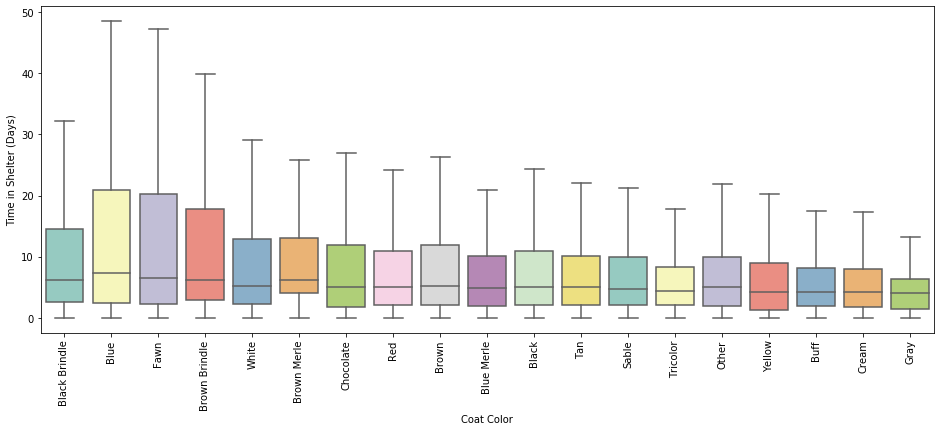

In [122]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='color_category', y='time_in_shelter_days', 
                    data=dog_coats, palette='Set3', showfliers=False, order=sort_color)
plt.xlabel('Coat Color')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

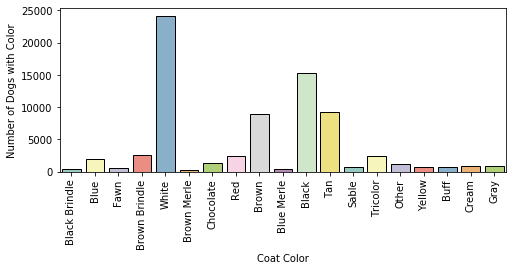

In [123]:
plt.figure(figsize=(8, 3))
sns.barplot(x=dog_coats.groupby('color_category').count().index, 
            y=dog_coats.groupby('color_category').count()['color'], 
            data=dog_coats.groupby('color_category').count(), palette='Set3', 
            order=sort_color, ec='black')
plt.xlabel('Coat Color')
plt.ylabel('Number of Dogs with Color')
plt.xticks(rotation=90)

## Being multicolor versus single colored seems to have almost no affect on adoption time.

Text(0, 0.5, 'Time in Shelter (Days)')

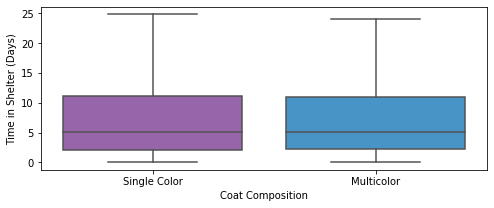

In [124]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
plt.figure(figsize=(8, 3))
sns.boxplot(x='multicolor', y='time_in_shelter_days',
                    data=dog_coats, palette=flatui, showfliers=False)
plt.xlabel('Coat Composition')
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Number of Dogs')

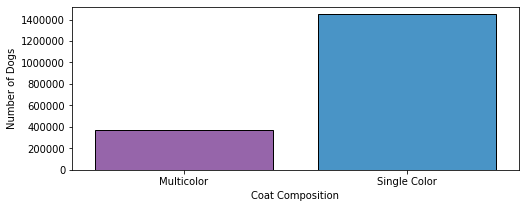

In [125]:
plt.figure(figsize=(8, 3))
sns.barplot(x=dog_coats.groupby('multicolor').count().index, 
            y=dog_coats.groupby('multicolor').count()['color'], 
            data=dog_coats.groupby('multicolor').count(), palette=flatui, 
            ec='black')
plt.xlabel('Coat Composition')
plt.ylabel('Number of Dogs')

# So, what if we only look at dogs that have unusually long adoption times?
For many of the above boxplots, there were so many outliers that the graphs were impossible to read with outliers shown, as shown here:

Text(0, 0.5, 'Time in Shelter (Days)')

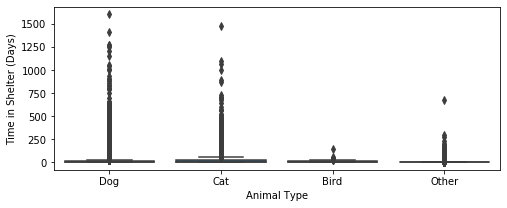

In [126]:
plt.figure(figsize=(8,3))
sns.boxplot(x='animal_type', y='time_in_shelter_days', palette='Paired', 
            data=df, order=['Dog', 'Cat', 'Bird', 'Other'])
plt.xlabel('Animal Type')
plt.ylabel('Time in Shelter (Days)')

A closer look at the distribution of the adoption times shows that the vast majority of the animals were adopted in <20 days, with a small handful (<5%) of animals having adoption times of more than 71 days.

In [127]:
stats.percentileofscore(df.time_in_shelter_days,100)

97.30018074103826

In [128]:
stats.percentileofscore(df.time_in_shelter_days,72)

95.11748167486695

In [129]:
df.time_in_shelter_days.quantile(0.95)

71.10881944444444

Looking only at the lower 95% of the data and by increasing the bins to 100, we can see that the mean is quite a bit higher than the median - in fact, it is greater than the 75th percentile of the data. This shows why the boxplots were so difficult to read - there are outliers so extreme that we're unable to see the majority of the data.

Text(0.5, 0, 'Time in Shelter (Days)')

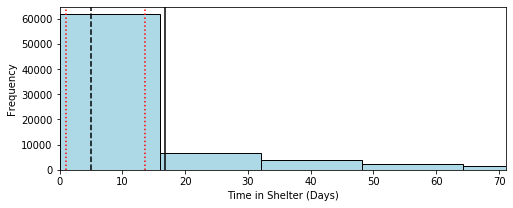

In [130]:
plt.figure(figsize=(8,3))
ax = df.time_in_shelter_days.plot(kind='hist', bins=100, color='LightBlue', ec='black')
plt.axis(xmin=0, xmax=(df.time_in_shelter_days.quantile(0.95)))
plt.axvline(df.time_in_shelter_days.mean(), c='black')
plt.axvline(df.time_in_shelter_days.median(), linestyle='--', c='black')
plt.axvline(df.time_in_shelter_days.quantile(0.25), linestyle=':', c='red')
plt.axvline(df.time_in_shelter_days.quantile(0.75), linestyle=':', c='red')
ax.set_xlabel('Time in Shelter (Days)')

Based on this analysis, we will only look at dogs with adoption times of > the 95th percentile (about 71 days) below.

Text(0.5, 0, 'Time in Shelter (Days)')

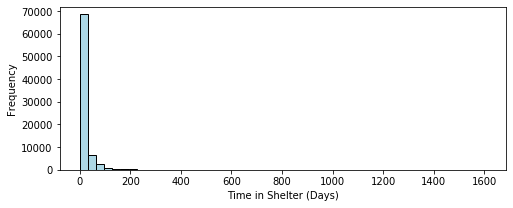

In [131]:
plt.figure(figsize=(8,3))
ax = df.time_in_shelter_days.plot(kind='hist', bins=50, color='LightBlue', ec='black')
ax.set_xlabel('Time in Shelter (Days)')

In [132]:
df.time_in_shelter_days.sort_values(ascending=False).head()

5500     1606.194444
10356    1478.200000
12123    1411.147917
18263    1268.975000
17795    1268.872917
Name: time_in_shelter_days, dtype: float64

# For these outliers (dogs with adoption times >95% of the adoption time distribution - about 71 days), do breed, mixed breed/purebred status, breed group, age, and coat color affect adoption times?

# Cats may take longer to adopt most of the time, but if an animal is in the shelter for a truly long time, it's more likely to be a dog.
And, apparently, very unlikely to be a bird.

Text(0, 0.5, 'Time in Shelter (Days)')

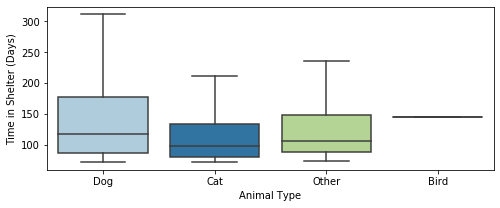

In [133]:
df_outliers = df.loc[df['time_in_shelter_days'] > (df.time_in_shelter_days.quantile(0.95)),:]

plt.figure(figsize=(8,3))
sns.boxplot(x='animal_type', y='time_in_shelter_days', palette='Paired', data=df_outliers, showfliers=False)
plt.xlabel('Animal Type')
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Number of Animals')

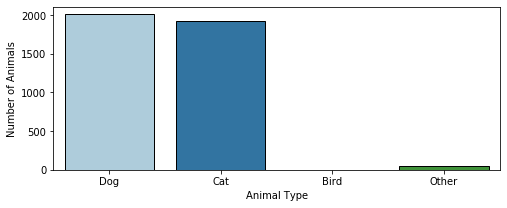

In [134]:
plt.figure(figsize=(8, 3))
sns.barplot(x=df_outliers.groupby('animal_type').count().index, 
            y=df_outliers.groupby('animal_type').count()['age_upon_outcome'], 
            data=df_outliers.groupby('animal_type').count(), palette='Paired', 
            ec='black', order=['Dog', 'Cat', 'Bird', 'Other'])
plt.xlabel('Animal Type')
plt.ylabel('Number of Animals')

## Dogs with outlier adoption times

In [135]:
dog_outliers = df_outliers[df_outliers['animal_type'] == 'Dog']

dog_outliers['breed'] = dog_outliers['breed'].str.replace('Black/Tan Hound', 'Black-Tan Hound')
dog_outliers['breed'] = dog_outliers['breed'].str.replace(' Shorthair', '')
dog_outliers['breed'] = dog_outliers['breed'].str.replace(' Longhair', '')
dog_outliers['breed_nomix'] = dog_outliers['breed'].str.replace(' Mix', '')
dog_outliers['breed_list'] = dog_outliers['breed_nomix'].str.split('/')
dog_outliers.loc[dog_outliers.breed_list.str.len()>1, 'mixed_breed'] = 'Mixed Breed'
dog_outliers.loc[dog_outliers['breed'].str.contains('Mix'), 'mixed_breed'] = 'Mixed Breed'
dog_outliers['mixed_breed'] = dog_outliers['mixed_breed'].fillna('Purebred')

has_breeds_outliers = pd.get_dummies(dog_outliers['breed_list'].apply(pd.Series).stack()).sum(level=0)

breeds_combined_outliers = pd.concat([dog_outliers, has_breeds_outliers], axis=1)

In [136]:
outlier_melt1 = breeds_combined_outliers[['breed_list', 'mixed_breed', 'time_in_shelter_days']]
outlier_melt2 = breeds_combined_outliers.loc[:, 'Akita':]
outlier_melt = pd.concat([outlier_melt1, outlier_melt2], axis=1)
breed_outliers = pd.melt(outlier_melt, id_vars=['breed_list','mixed_breed','time_in_shelter_days'], var_name='breed_name', value_name='has_breed')
breed_outliers.loc[breed_outliers['has_breed']==1, 'breed'] = breed_outliers['breed_name']

As before, there are many cases where animals only appear once or a few times in the data. I grouped breeds that do not appear commonly using quartiles and determined that animals that occur <8 times would be grouped as "other".

In [137]:
breed_outliers.groupby('breed').sum().sort_values('has_breed',ascending=False)['has_breed'].quantile(.75)

10.0

In [138]:
common_breeds_outliers = breed_outliers.groupby('breed').sum()
common_breeds_outliers = common_breeds_outliers.sort_values('has_breed', ascending=False)
other_breeds_outliers = common_breeds_outliers.loc[common_breeds_outliers['has_breed']<(breed_outliers.groupby('breed').sum().sort_values('has_breed',ascending=False)['has_breed'].quantile(.75)),:]
other_breeds_list_outliers = other_breeds_outliers.index.tolist()

breed_outliers.loc[breed_outliers['breed'].isin(other_breeds_list_outliers), 'breed_category'] = 'Other'
breed_outliers.loc[~breed_outliers['breed'].isin(other_breeds_list_outliers), 'breed_category'] = breed_outliers['breed']

# Dachshunds, American Bulldogs, and Catahoulas have the longest adoption times of dogs in this outlier group.
Note that purebreds almost never appear in this outlier group: only 65 of these datapoints are purebreds.


<img src="https://dogsaholic.com/wp-content/uploads/2018/02/главная-5.jpg" width=400px align="center"><br>
[Image Credit](https://dogsaholic.com/names/dachshund-names.html)<br>


In [139]:
sortgroup_outliers = breed_outliers.groupby('breed_category').mean().sort_values('time_in_shelter_days', ascending=False)
sortgroup_outliers = sortgroup_outliers['time_in_shelter_days'].to_dict()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

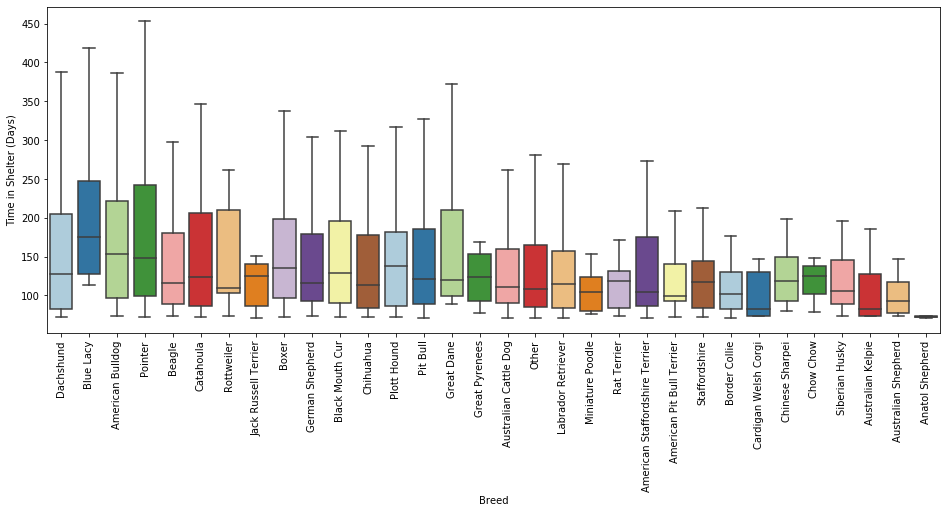

In [140]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='breed_category', y='time_in_shelter_days', 
                    data=breed_outliers, palette='Paired', showfliers=False, order=sortgroup_outliers)
plt.xlabel('Breed')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

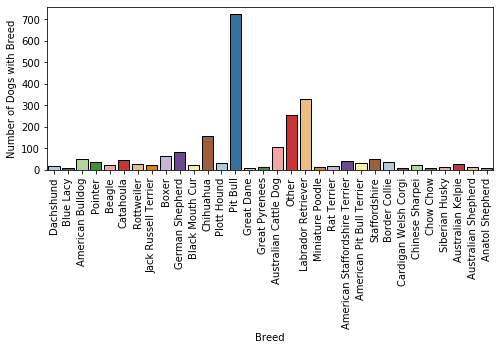

In [141]:
plt.figure(figsize=(8, 3))
sns.barplot(x=breed_outliers.groupby('breed_category').count().index, 
            y=breed_outliers.groupby('breed_category').count()['breed'], 
            data=breed_outliers.groupby('breed_category').count(), palette='Paired', 
            ec='black',order=sortgroup_outliers)
plt.xlabel('Breed')
plt.ylabel('Number of Dogs with Breed')
plt.xticks(rotation=90)

# The Hound Group has the longest adoption times in dogs that have excessively long adoption times. Additionally, the Toy Group is more highly represented in these outliers.
It's worth noting here that Dachshunds are part of the Hound Group, so this makes sense.

This time, I only looked based on the breed group categorizations determined above: breeds appearing <8 times were grouped together as "other".

In [142]:
breed_groups_outliers = pd.merge(left=breed_outliers, right=dog_groups, left_on='breed_category', right_on='Breed')
breed_groups_outliers = breed_groups_outliers[breed_groups_outliers['American Kennel Club[4]'].isin(AKCgroups)]

In [143]:
sortbreedgroup_outliers = breed_groups_outliers.groupby('American Kennel Club[4]').mean().sort_values('time_in_shelter_days', ascending=False)
sortbreedgroup_outliers = sortbreedgroup_outliers['time_in_shelter_days'].to_dict()

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

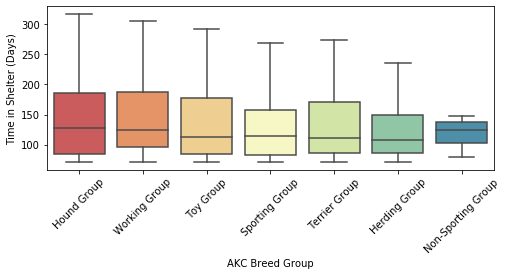

In [144]:
plt.figure(figsize=(8,3))
sns.boxplot(x='American Kennel Club[4]', y='time_in_shelter_days', 
            data=breed_groups_outliers, palette='Spectral', 
            showfliers=False, order=sortbreedgroup_outliers)
plt.xlabel('AKC Breed Group')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

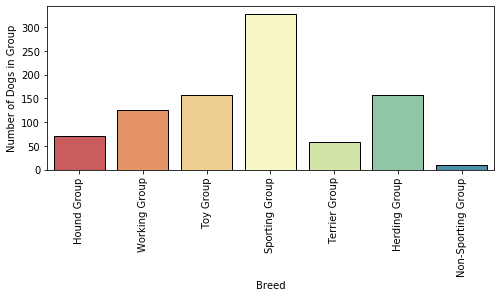

In [145]:
plt.figure(figsize=(8, 3))
sns.barplot(x=breed_groups_outliers.groupby('American Kennel Club[4]').count().index, 
            y=breed_groups_outliers.groupby('American Kennel Club[4]').count()['breed_name'], 
            data=breed_groups_outliers.groupby('American Kennel Club[4]').count(), palette='Spectral', 
            order=sortbreedgroup_outliers, ec='black')
plt.xlabel('Breed')
plt.ylabel('Number of Dogs in Group')
plt.xticks(rotation=90)

# There are substantially fewer purebreeds in the outlier group than mixed breeds, and mixed breeds still have longer adoption times.

Text(0, 0.5, 'Time in Shelter (Days)')

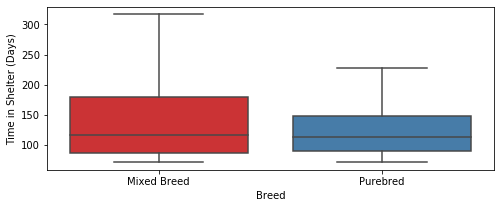

In [146]:
plt.figure(figsize=(8,3))
sns.boxplot(x='mixed_breed', y='time_in_shelter_days', 
                    data=breed_outliers, palette='Set1', showfliers=False)
plt.xlabel('Breed')
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Number of Dogs in Group')

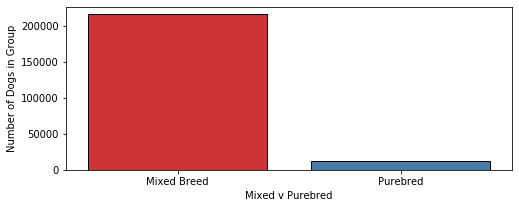

In [147]:
plt.figure(figsize=(8, 3))
sns.barplot(x=breed_outliers.groupby('mixed_breed').count().index, 
            y=breed_outliers.groupby('mixed_breed').count()['breed_name'], 
            data=breed_outliers.groupby('mixed_breed').count(), palette='Set1', 
            ec='black')
plt.xlabel('Mixed v Purebred')
plt.ylabel('Number of Dogs in Group')

# Age is a much larger factor for dogs that have long adoption times.
Here, it is easy to see that younger dogs are adopted more quickly.

In [148]:
dog_outliers['age_group'] = dog_outliers['age_upon_outcome_age_group'].str[1:-1]
dog_outliers['age_group'] = dog_outliers['age_group'].str.replace(', ','-')

Text(0, 0.5, 'Time in Shelter (Days)')

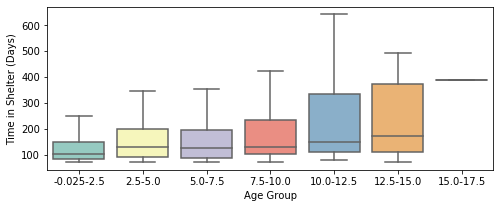

In [149]:
plt.figure(figsize=(8,3))
sns.boxplot(x='age_group', y='time_in_shelter_days', 
            data=dog_outliers, palette='Set3', 
            showfliers=False, order=['-0.025-2.5', '2.5-5.0', '5.0-7.5', 
                                     '7.5-10.0', '10.0-12.5', '12.5-15.0',
                                    '15.0-17.5'])
plt.xlabel('Age Group')
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Number of Dogs in Group')

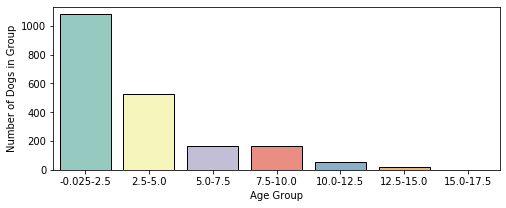

In [150]:
plt.figure(figsize=(8, 3))
sns.barplot(x=dog_outliers.groupby('age_group').count().index, 
            y=dog_outliers.groupby('age_group').count()['age_upon_outcome'], 
            data=dog_outliers.groupby('age_group').count(), palette='Set3', 
            ec='black', order=['-0.025-2.5', '2.5-5.0', '5.0-7.5',
                               '7.5-10.0', '10.0-12.5', '12.5-15.0',
                               '15.0-17.5'])
plt.xlabel('Age Group')
plt.ylabel('Number of Dogs in Group')

## Is Black Dog Syndrome more prevalent in dogs with long adoption times?
As before, I parsed mixed coat colors to look at individual colors separately.

In [151]:
dog_outliers['coat_color_list'] = dog_outliers['color'].str.split('/')
dog_outliers.loc[dog_outliers.coat_color_list.str.len()>1, 'multicolor'] = 'Multicolor'
dog_outliers.loc[dog_outliers['color'].str.contains('Tricolor'), 'multicolor'] = 'Multicolor'
dog_outliers['multicolor'] = dog_outliers['multicolor'].fillna('Single Color')
coat_colors_outliers = pd.get_dummies(dog_outliers['coat_color_list'].apply(pd.Series).stack()).sum(level=0)

In [152]:
coat_colors_combined_outliers = pd.concat([dog_outliers, coat_colors_outliers], axis=1)

In [153]:
coat1_outliers = coat_colors_combined_outliers[['color', 'coat_color_list', 'multicolor', 'time_in_shelter_days']]
coat2_outliers = coat_colors_combined_outliers.loc[:, 'Apricot':]
coat_melt_outliers = pd.concat([coat1_outliers, coat2_outliers], axis=1)
dog_coats_outliers = pd.melt(coat_melt_outliers, id_vars=['color', 'coat_color_list', 'multicolor','time_in_shelter_days'], 
                       var_name='coat_color', value_name='has_color')
dog_coats_outliers.loc[dog_coats_outliers['has_color']==1, 'colored'] = dog_coats_outliers['coat_color']

Similarly to breed in this outlier group, I used quartiles to determine how to group "other" colors (less frequently occuring colors).

In [154]:
common_colors_outliers = dog_coats_outliers.groupby('colored').count()
common_colors_outliers = common_colors_outliers.sort_values('has_color', ascending=False)
other_colors_outliers = common_colors_outliers.loc[common_colors_outliers['has_color']<60,:]
other_colors_list_outliers = other_colors_outliers.index.tolist()

In [155]:
dog_coats_outliers.loc[dog_coats_outliers['colored'].isin(other_colors_list_outliers), 'color_category'] = 'Other'
dog_coats_outliers.loc[~dog_coats_outliers['colored'].isin(other_colors_list_outliers), 'color_category'] = dog_coats_outliers['colored']

In [156]:
sort_color_outliers = dog_coats_outliers.groupby('color_category').mean().sort_values('time_in_shelter_days', ascending=False)
sort_color_outliers = sort_color_outliers['time_in_shelter_days'].to_dict()

# Dark coat colors do appear in dogs with longer adoption times; however, they are not significantly longer than light colors.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

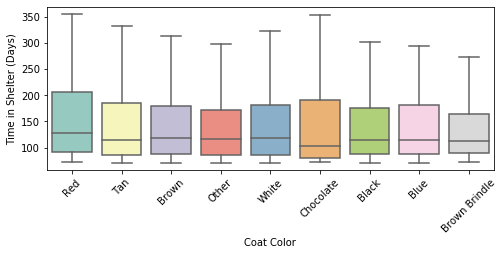

In [157]:
plt.figure(figsize=(8,3))
sns.boxplot(x='color_category', y='time_in_shelter_days',
                    data=dog_coats_outliers, palette='Set3', showfliers=False, order=sort_color_outliers)
plt.xlabel('Coat Color')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

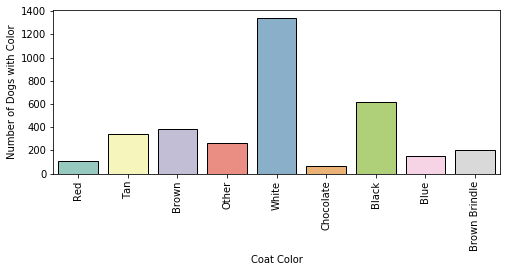

In [158]:
plt.figure(figsize=(8, 3))
sns.barplot(x=dog_coats_outliers.groupby('color_category').count().index, 
            y=dog_coats_outliers.groupby('color_category').count()['color'], 
            data=dog_coats_outliers.groupby('color_category').count(), palette='Set3', 
            order=sort_color_outliers, ec='black')
plt.xlabel('Coat Color')
plt.ylabel('Number of Dogs with Color')
plt.xticks(rotation=90)

## Having a single color vs. multicolor coat also does not affect adoption time in dogs with long adoption times.

Text(0, 0.5, 'Time in Shelter (Days)')

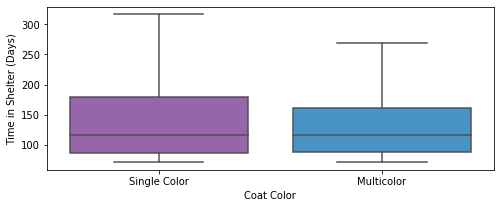

In [159]:
plt.figure(figsize=(8,3))
sns.boxplot(x='multicolor', y='time_in_shelter_days',
                    data=dog_coats_outliers, palette=flatui, showfliers=False)
plt.xlabel('Coat Color')
plt.ylabel('Time in Shelter (Days)')

Text(0, 0.5, 'Number of Dogs')

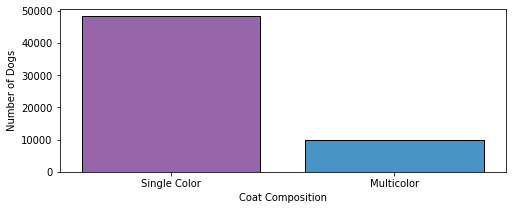

In [160]:
plt.figure(figsize=(8, 3))
sns.barplot(x=dog_coats_outliers.groupby('multicolor').count().index, 
            y=dog_coats_outliers.groupby('multicolor').count()['color'], 
            data=dog_coats_outliers.groupby('multicolor').count(), palette=flatui, 
            ec='black', order=['Single Color', 'Multicolor'])
plt.xlabel('Coat Composition')
plt.ylabel('Number of Dogs')

# Pets are more likely to be adopted during the Spring and Summer months.

In [161]:
times = df.set_index('outcome_datetime')
times = times.sort_index()
times['adoption_count'] = 1
times = times['adoption_count']

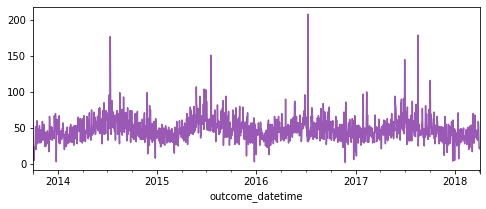

In [162]:
plt.figure(figsize=(8,3))
times.resample('1D').count().plot()

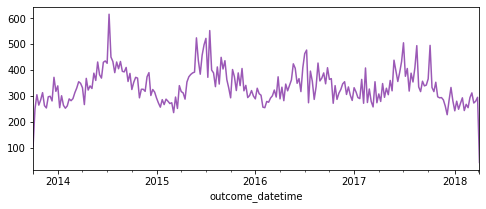

In [163]:
plt.figure(figsize=(8,3))
times.resample('1W').count().plot()

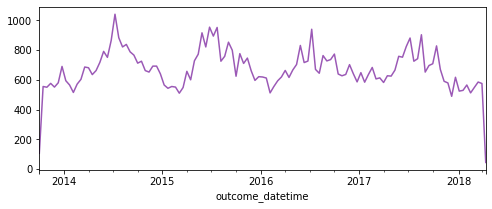

In [164]:
plt.figure(figsize=(8,3))
times.resample('2W').count().plot()

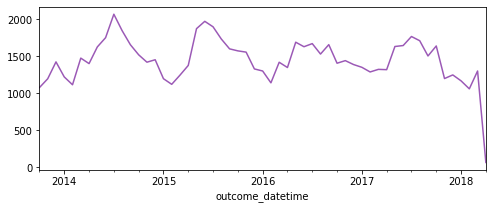

In [165]:
plt.figure(figsize=(8,3))
times.resample('1M').count().plot()

# Pets are more likely to be adopted later in the day, with a significant increase between 4:00 and 7:00 PM.

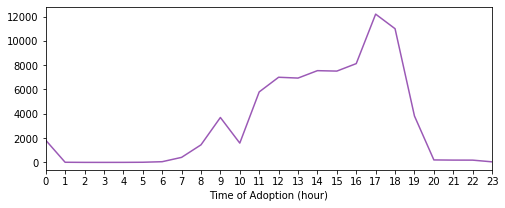

In [166]:
plt.figure(figsize=(8,3))
ax = times.groupby(times.index.hour).sum().plot()
ax.set_xlabel('Time of Adoption (hour)')
ax.set_xticks(times.groupby(times.index.hour).sum().index)
#ax.set_xticklabels(range(1,25))

In [167]:
times = times.reset_index()
times['time_of_day'] = times['outcome_datetime'].dt.hour + times['outcome_datetime'].dt.minute/60

(0, 24)

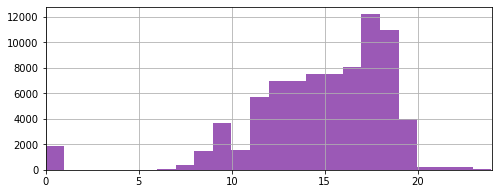

In [168]:
plt.figure(figsize=(8,3))
times['time_of_day'].hist(bins=24)
plt.xlim(0,24)

## This peak later in the day could be the result of prospective pet parents coming home from work; however, the peak is highest on Sunday, followed by Monday.

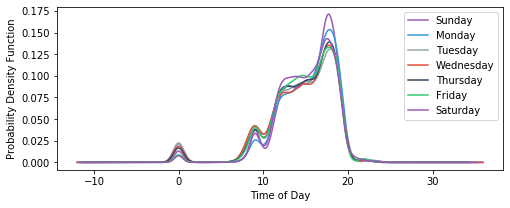

In [169]:
times['day_of_week'] = times['outcome_datetime'].dt.weekday_name
times['day_of_week'] = pd.Categorical(times['day_of_week'], ordered=True, 
                                      categories=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 
                                                  'Thursday', 'Friday', 'Saturday'])
days = times['day_of_week'].cat.categories
plt.figure(figsize=(8,3))
for day in days:
    ax = times[times.day_of_week==day].time_of_day.plot(kind='density')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Probability Density Function')
plt.legend(days)

# Weekends are the most common times to adopt pets, too, with Wednesday through Friday having the least adoptions.

In [170]:
times.groupby('day_of_week').sum()['adoption_count']

day_of_week
Sunday       12312
Monday       11429
Tuesday      11690
Wednesday    10456
Thursday     10217
Friday       10735
Saturday     12833
Name: adoption_count, dtype: int64

In [171]:
adoption_days = times.groupby(times['outcome_datetime'].dt.date).sum().reset_index()
adoption_days['outcome_datetime'] = pd.to_datetime(adoption_days['outcome_datetime'])
adoption_days['day_of_week'] = adoption_days['outcome_datetime'].dt.weekday_name

Text(0, 0.5, 'Distribution of Adoptions')

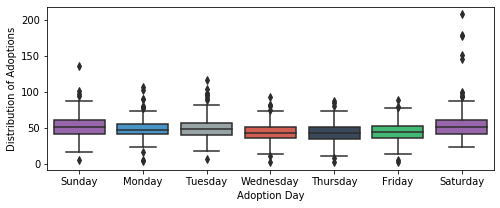

In [172]:
weekdays = {'Sunday': 1, 'Monday':2, 'Tuesday':3, 'Wednesday':4, 'Thursday':5, 'Friday':6, 'Saturday':7}
plt.figure(figsize=(8,3))
ax = sns.boxplot(x='day_of_week', y='adoption_count', data=adoption_days, palette=flatui, order=weekdays)
ax.set_xlabel('Adoption Day')
plt.ylabel('Distribution of Adoptions')